In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.path import Path
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches
from matplotlib import patches
from hiveplotlib import hive_plot_n_axes
from hiveplotlib.converters import networkx_to_nodes_edges
from hiveplotlib.node import split_nodes_on_variable
from hiveplotlib.viz import hive_plot_viz
from collections import defaultdict
import community as community_louvain
import seaborn as sns
import random
import networkx as nx
import joblib
import subprocess
import json

In [2]:
os.getcwd()

'c:\\Users\\samue\\OneDrive\\Documenti\\Studio\\Università\\Tesi\\Progetto\\Ricerca\\Script\\Enrichment'

In [3]:
dataset = pd.read_csv("../../SYMBOL/Dataset/MergedDatasetFullCombat_symbol.csv")
print(list(dataset.T.index))

['SampleID', 'Label', 'TRAK2', 'MARCHF5', 'AVIL', 'CLSTN1', 'TAPBPL', 'TRIM38', 'GDF11', 'TBXA2R', 'SPAST', 'MCM3', 'OSBP', 'SLC50A1', 'USP1', 'ZNF222', 'ATG3', 'ZFPL1', 'ERP44', 'HAPSTR1', 'TMSB15B', 'EHMT1', 'BPI', 'ABHD4', 'ADRA2A', 'UBB', 'SDHAF3', 'LPCAT3', 'CSTF2T', 'IFIH1', 'ANAPC1', 'FCER2', 'CEP192', 'TULP4', 'LFNG', 'MAP3K4', 'KLF7', 'TJP2', 'PLAG1', 'CD2', 'ICOSLG', 'TBL2', 'JHY', 'BCAS2', 'FBXL5', 'EMC2', 'ELK4', 'MCTP2', 'ABCF3', 'TRIM26', 'HNRNPK', 'XPC', 'CCDC6', 'CCDC85B', 'HBD', 'AP3B1', 'AASDHPPT', 'NFKBIA', 'ATP6V0B', 'PTOV1', 'OSBPL10', 'SLC25A42', 'HAGH', 'C2orf42', 'NDUFA3', 'NECTIN2', 'ZBTB17', 'NOCT', 'TGFBRAP1', 'TMEM115', 'BLVRA', 'LAX1', 'IL15', 'KARS1', 'FKBP2', 'GAS7', 'INPPL1', 'PIP5K1B', 'TBKBP1', 'NDUFAF7', 'GCLC', 'PRSS23', 'CD248', 'PTDSS2', 'EFHD2', 'PLA2G4C', 'IL13RA1', 'ADGRL1', 'FHOD1', 'MRPL22', 'MAF', 'COASY', 'ZNF580', 'YARS2', 'RAB14', 'EMC10', 'PTBP1', 'RXRA', 'RPRD1A', 'ARPC4', 'AAMP', 'MAPK4', 'UTP6', 'ANKRD53', 'AMZ2', 'STK39', 'PTPN11', 'O

<h2>Analisi di quanti geni importanti SHAP considerare</h2>

In [61]:
path = "../../SYMBOL/Results/"
knownImportant =  ["PDC1", "GABPA", "CTCF", "EGR1", "YY1", "SPI1", "CLOCK", "ARNTL", "BACH1", "GFI1", "IFNB1", "MOG",  "MBP", "CD42", "IFNG", "IL17A", "IL10", "TNF", "IL1B", "IL6", "TNFRSF1A", "CYP27B1", "IL7R", "HLA-DRB1", "HLA-DRB5", "IL2RA"]

def addGeneClusters(geneDict, clusters):
    clusters = inverDict(clusters)
    resultValues = list(geneDict.values())
    resultKeys = list(geneDict.keys())

    for gene, cluster in clusters.items():
        if gene in list(geneDict.keys()):
            insertGenes = list(set(cluster) - set([gene]))
            idx = resultKeys.index(gene)
            resultValues[idx+1:idx+1] = [resultValues[idx]] * len(insertGenes)
            resultKeys[idx+1:idx+1] = insertGenes

    return dict(zip(resultKeys, resultValues))

def inverDict(d):
    inverted = defaultdict(list)

    for keys_tuple, value in d.items():
        inverted[value].extend(list(keys_tuple))

    return dict(inverted)

def importanceAnalysis(expl, sigma=1, threshold=80):
    non_zeroShap = [value for value in expl['MeanAbsoluteShap']]
    mean = np.mean(non_zeroShap)
    std = np.std(non_zeroShap)

    print('Mean:', mean)
    print('Stadnard Deviation:', std)

    k=sigma
    bestFeatures = [key for key, value in expl[['Feature', 'MeanAbsoluteShap']].values if value > (k*std)+mean]
    print(f"Number of features over {k} sigma:", len(bestFeatures), bestFeatures)

    plt.close()
    plt.figure(figsize=(10,5))
    sns.histplot(data=non_zeroShap, bins=100)
    plt.yscale('log')
    plt.title('Distribution of feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Density')
    plt.axvline(mean, color='red', linestyle='--', label='Mean')
    plt.axvline(mean+std, color='orange', linestyle='--', label='Mean + 1σ')
    plt.axvline(mean+2*std, color='green', linestyle='--', label='Mean + 2σ')
    plt.axvline(mean+3*std, color='blue', linestyle='--', label='Mean + 3σ')
    plt.legend()
    plt.show()

    cumulativeImportance = (np.array(list(expl[['MeanAbsoluteShap']].values)).cumsum() / np.array(list(expl[['MeanAbsoluteShap']].values)).sum()) * 100

    microarray_num_features_80 = np.argmax(cumulativeImportance >= threshold)+1  # +1 per contare da 1, non da 0
    print(f"Numero di feature necessarie per raggiungere almeno l'{threshold}% dell'importanza cumulativa: {microarray_num_features_80}")

    plt.close()
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(cumulativeImportance)+1), cumulativeImportance)
    plt.xlabel('Number of non-zero importance features')
    plt.ylabel('Cumulative Importance (%)')
    plt.title('Cumulative Importance of Features')
    plt.grid()
    plt.show()

    return microarray_num_features_80, len(bestFeatures)

<h3>Microarray</h3>

In [5]:
microarray_expl=  joblib.load(path + "DatasetFull/xgbDefFull_explSorted.pkl")
microarray_explanations = pd.DataFrame(microarray_expl.items(), columns=['Feature', 'MeanAbsoluteShap'])

for gene, importance in microarray_expl.items():
    if gene in knownImportant and importance != 0:
        print(f"{gene}: {importance}, {microarray_explanations[microarray_explanations['Feature'] == gene].index}")

HLA-DRB1: 0.28484796561932874, Index([2], dtype='int64')
HLA-DRB5: 0.23398413513076485, Index([4], dtype='int64')
EGR1: 0.023358725687356103, Index([266], dtype='int64')
IL2RA: 0.011317212764094796, Index([475], dtype='int64')
IL1B: 0.009413894418347123, Index([533], dtype='int64')


Mean: 0.030925875462513325
Stadnard Deviation: 0.04246750068373472
Number of features over 0 sigma: 205 ['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FAAH', 'PLLP',

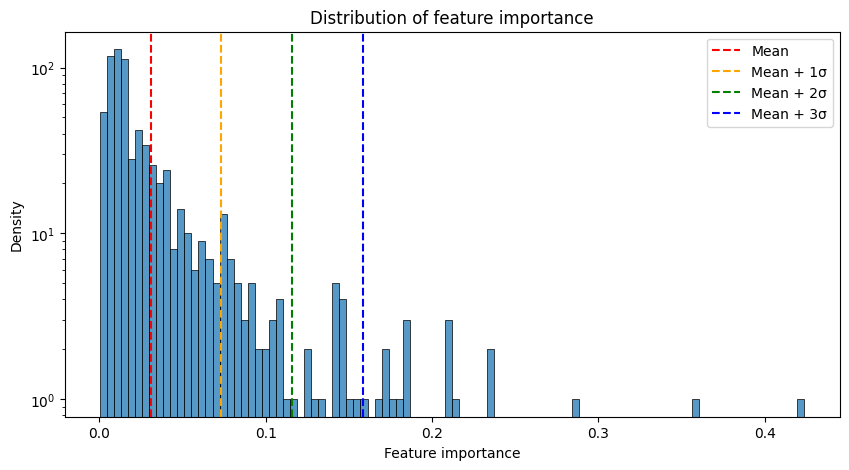

Numero di feature necessarie per raggiungere almeno l'99.99999% dell'importanza cumulativa: 724


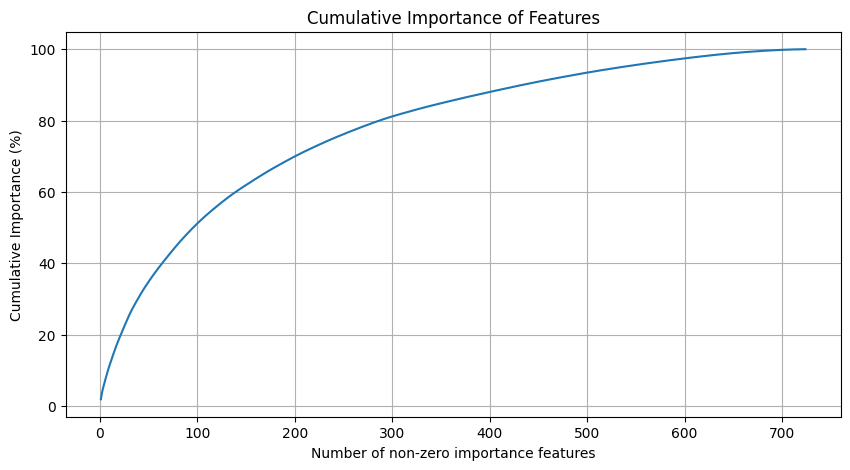

In [6]:
microarray_explNonZero = microarray_explanations[microarray_explanations['MeanAbsoluteShap'] != 0]

microarraySelectedFeatures, microarraySigmaFeatures = importanceAnalysis(microarray_explNonZero, sigma=0, threshold=99.99999)

In [67]:
# microarray_explNonZero_dict = dict(zip(microarray_explNonZero['Feature'][:microarraySigmaFeatures], microarray_explNonZero['MeanAbsoluteShap'][:microarraySigmaFeatures]))
microarray_explNonZero_dict = dict(zip(microarray_explNonZero['Feature'][:500], microarray_explNonZero['MeanAbsoluteShap'][:500]))
microarray_cluster = joblib.load(path + "DatasetFull/uniqueClustersFULL.pkl")

microarray_80_enriched = addGeneClusters(microarray_explNonZero_dict, microarray_cluster)

for gene in microarray_explNonZero_dict.keys():
    if gene not in microarray_80_enriched:
        print(f"{gene} not in microarray_80_enriched")

print(len(microarray_explNonZero_dict), "-->", len(microarray_80_enriched))

500 --> 500


In [68]:
print(list(microarray_80_enriched.keys()))

['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FAAH', 'PLLP', 'GNLY', 'PANK4', 'LPCAT3', 'ZNF80', 'KIAA0408', 'SDK2', 'CHAF1A', 'FEZ1', 'IL32', 'EIF2AK2', 'RBM4', 'C

In [63]:
print(microarray_expl)

{'ABCA1': 0.42377776283466634, 'NDUFS5': 0.3599050004923352, 'HLA-DRB1': 0.28484796561932874, 'CROCC': 0.23561278175067588, 'HLA-DRB5': 0.23398413513076485, 'KLF3-AS1': 0.21342996862072747, 'SPATA7': 0.21138137835470483, 'EIF2S2': 0.2109245362167198, 'MRFAP1L1': 0.20882398229173116, 'DNAAF11': 0.1861498099477038, 'MAMLD1': 0.18546270353927777, 'FOXRED2': 0.18288684168858338, 'LILRA2': 0.18088312908868937, 'MUC1': 0.175282587143296, 'SFSWAP': 0.17320766953981148, 'CTSG': 0.17203436551048554, 'SRSF11': 0.16574600106839119, 'SPATA2': 0.15846233858609407, 'CD163': 0.15371651670143674, 'GPR68': 0.14969893733267378, 'PPP2R1A': 0.14723453337029657, 'ADAT1': 0.1454765385455316, 'SEC14L1': 0.1448585185989097, 'HDC': 0.14472861849621266, 'CRTAP': 0.14271759805736073, 'FKBP5': 0.14221343024269112, 'ZNF473': 0.14084543384486664, 'NOL11': 0.1407972638809925, 'ERICH1': 0.14041240065139654, 'TMX4': 0.13291124768151383, 'RFTN1': 0.1289153791200694, 'TMT1A': 0.12445545419938442, 'ING2': 0.1236391119662

<h3>B cells CSF</h3>

In [69]:
csf_B_explanations = joblib.load(path + "BCELLS_CSF_EXPL.pkl")
csf_B_expl = dict(zip(csf_B_explanations["Feature"], csf_B_explanations["MeanAbsoluteShap"]))

for gene, importance in csf_B_expl.items():
    if gene in knownImportant and importance != 0:
        print(f"{gene}: {importance}, {csf_B_explanations[csf_B_explanations['Feature'] == gene].index}")

MOG: 0.003184202167580059, Index([608], dtype='int64')
HLA-DRB5: 0.003140617576522289, Index([613], dtype='int64')


Mean: 0.004093530326497527
Stadnard Deviation: 0.01501567435899282
Number of features over 0 sigma: 501 ['CD300LD', 'LRRC8E', 'LINC00332', 'RPLP1', 'ACTN3', 'GATA3-AS1', 'LRRC10', 'TMEM74', 'ANO9', 'AMIGO3', 'PIK3R3', 'LAPTM5', 'KRTAP12-3', 'EIF1', 'LINC01209', 'MT-CO1', 'SLC4A9', 'DSG2-AS1', 'XKRX', 'TOX', 'FCGR2A', 'LINC01030', 'GPRIN1', 'PI16', 'HTN1', 'LINC00700', 'TYROBP', 'LINC01149', 'LINC01257', 'PNCK', 'AC084149.1', 'ZNF215', 'BLK', 'SLC9A3R2', 'FOXB1', 'ZNF610', 'ASB13', 'LINC01115', 'AC002454.1', 'ZBED9', 'BTNL3', 'TAS1R3', 'SARDH', 'ADORA2A', 'OR1L3', 'TSPAN13', 'MYB', 'PBX1', 'GCHFR', 'FANCD2', 'LINC00159', 'FAM201A', 'HGD', 'MEIOB', 'IGHV3-30', 'LINC01562', 'PPFIA3', 'LINC00589', 'RTP1', 'OTX1', 'FGF11', 'C22orf23', 'NIM1K', 'PRRG1', 'ZNF729', 'FAM171A2', 'PSG8', 'CCDC183-AS1', 'EFCAB6-AS1', 'LGI4', 'LINC01287', 'TDRD15', 'LINC00668', 'SGCE', 'IGKV2D-18', 'KRTAP10-1', 'SCN7A', 'SP5', 'OR2C3', 'LINC01470', 'TRAPPC10', 'RGSL1', 'LINC01116', 'FRMD1', 'TMSB4X', 'FAM71E1', 'PR

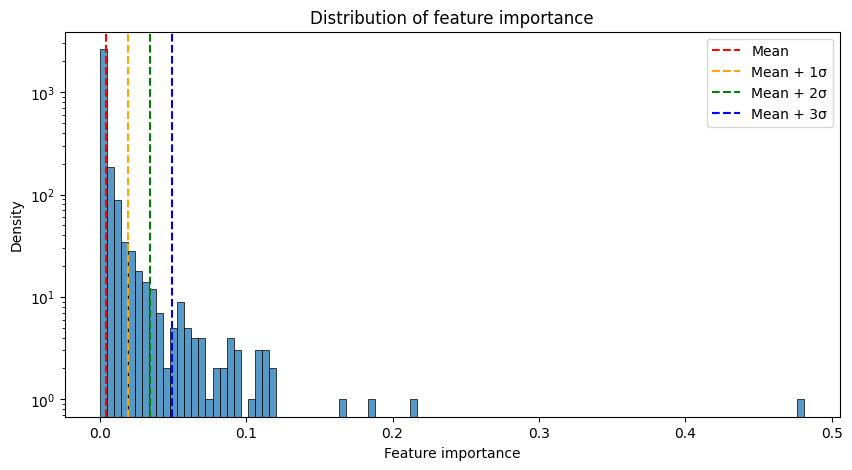

Numero di feature necessarie per raggiungere almeno l'80% dell'importanza cumulativa: 485


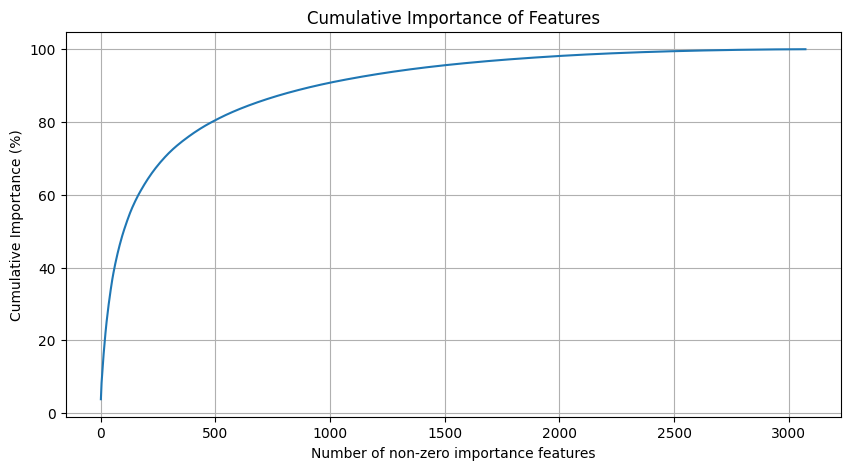

In [70]:
csf_B_explNonZero = csf_B_explanations[csf_B_explanations['MeanAbsoluteShap'] != 0]

csf_BSelectedFeatures, csf_BSigmaFeatures = importanceAnalysis(csf_B_explNonZero, sigma=0)

In [71]:
csf_B_explNonZero_dict = dict(zip(csf_B_explNonZero['Feature'][:500], csf_B_explNonZero['MeanAbsoluteShap'][:500]))
# csf_B_explNonZero_dict = dict(zip(csf_B_explNonZero['Feature'][:csf_BSelectedFeatures], csf_B_explNonZero['MeanAbsoluteShap'][:csf_BSelectedFeatures]))
csf_B_cluster = joblib.load(path + "BCELLS_CSF_uniqueClusters.pkl")

csf_B_80_enriched = addGeneClusters(csf_B_explNonZero_dict, csf_B_cluster)

for gene in csf_B_explNonZero_dict.keys():
    if gene not in csf_B_80_enriched:
        print(f"{gene} not in csf_B_80_enriched")

print(len(csf_B_explNonZero_dict), "-->", len(csf_B_80_enriched))

500 --> 1097


In [72]:
print(list(csf_B_80_enriched.keys()))

['CD300LD', 'LRRC8E', 'LINC00332', 'RPLP1', 'RPL41', 'RPS19', 'RPS12', 'RPL30', 'RPS3A', 'RPL7A', 'RPL22', 'FAU', 'RPS16', 'RPL19', 'RPL31', 'RPL13', 'RPL29', 'RPS20', 'RPL35A', 'RPL37A', 'RPL36', 'RPS11', 'RPL35', 'TOMM7', 'RPL18', 'RPL27A', 'RPS27A', 'RPL32', 'EEF1B2', 'PFDN5', 'RPLP2', 'RPS8', 'RPS25', 'RPL6', 'RPS17', 'RPL27', 'RPS6', 'RPS14', 'RPL37', 'RPL23', 'UBA52', 'RPL8', 'RPL11', 'RPL39', 'RPS13', 'RPS15', 'RPL28', 'RPL18A', 'RPL12', 'RPL23A', 'NACA', 'RPL21', 'RPL9', 'RPS23', 'RPS15A', 'RPL13A', 'RPL15', 'RPS24', 'RPL14', 'RPL26', 'RPL24', 'RPL34', 'RPL10', 'RPL38', 'RPS28', 'ACTN3', 'GATA3-AS1', 'LRRC10', 'TMEM74', 'ANO9', 'AMIGO3', 'PIK3R3', 'LAPTM5', 'KRTAP12-3', 'EIF1', 'LINC01209', 'MT-CO1', 'MTRNR2L8', 'MT-ND5', 'MT-CO3', 'MT-ND2', 'MT-CO2', 'MT-CYB', 'MT-ND4L', 'MT-ND3', 'MT-ND1', 'MT-ATP6', 'MT-ND4', 'MTRNR2L12', 'SLC4A9', 'DSG2-AS1', 'XKRX', 'TOX', 'FCGR2A', 'CXCL16', 'ADGRE2', 'P4HA1', 'SAT1', 'SUOX', 'SIRPA', 'CTSB', 'FGL2', 'PLXDC2', 'PLSCR1', 'ATP8B4', 'IFNGR2'

<h3>CD4 CSF</h3>

In [73]:
csf_CD4_explanations = joblib.load(path + "CD4_CSF_EXPL.pkl")
csf_CD4_expl = dict(zip(csf_CD4_explanations["Feature"], csf_CD4_explanations["MeanAbsoluteShap"]))

for gene, importance in csf_CD4_expl.items():
    if gene in knownImportant and importance != 0:
        print(f"{gene}: {importance}, {csf_CD4_explanations[csf_CD4_explanations['Feature'] == gene].index}")

EGR1: 0.038419715538392726, Index([41], dtype='int64')
HLA-DRB5: 0.004673444854347171, Index([2412], dtype='int64')
MOG: 0.003910204135877866, Index([3172], dtype='int64')
GABPA: 0.00333069203242359, Index([3995], dtype='int64')
MBP: 0.0031868384706675765, Index([4225], dtype='int64')
IL6: 0.0019123923667796984, Index([7041], dtype='int64')
IL1B: 0.001568825851791859, Index([8027], dtype='int64')
CYP27B1: 0.0012901416879201304, Index([8917], dtype='int64')
IL10: 0.0008097904218913146, Index([10444], dtype='int64')
CLOCK: 0.00010688086030980878, Index([12818], dtype='int64')


Mean: 0.0033815157752205946
Stadnard Deviation: 0.005564694730377876
Number of features over 0 sigma: 3929 ['ALDOA', 'MTRNR2L1', 'SPRED3', 'HNRNPH1', 'HOXB7', 'CPM', 'FZD2', 'CIDEC', 'PCDHGA8', 'HCFC2', 'KLF15', 'ELMO1-AS1', 'CASC2', 'LINC01535', 'AOAH', 'MBTPS2', 'AC006369.2', 'MSS51', 'CPB2-AS1', 'ITM2B', 'CITED2', 'PRR4', 'MIR99AHG', 'ALPK3', 'ANGEL1', 'CARD9', 'DRGX', 'FKBP1C', 'DRC3', 'ZNF543', 'LINC00964', 'GGA3', 'CD300E', 'TRBC1', 'ITGB8', 'RPA2', 'ZRANB2-AS1', 'WNT10B', 'TBC1D30', 'EPB42', 'TNFRSF10C', 'EGR1', 'AC159540.1', 'SLC6A8', 'ZNF18', 'LINC00678', 'SRPX', 'INPP1', 'WWC1', 'ARPIN', 'RPL17', 'FCER1A', 'IMPG2', 'FAM174A', 'ZNF235', 'PTMA', 'GDF11', 'HNRNPM', 'HIST1H3C', 'FAM110A', 'NHSL2', 'DLD', 'ZNF445', 'SMCO1', 'DOK1', 'ATXN8OS', 'HLA-G', 'EPB41L1', 'DLEU7', 'ACSM2B', 'C10orf88', 'CPVL', 'MYO1B', 'SLC25A1', 'EBLN1', 'MRM1', 'SGK3', 'AIF1L', 'GIPR', 'APOO', 'AC053503.4', 'LINC00467', 'NPIPB8', 'AC104699.1', 'TGM1', 'STKLD1', 'HECTD2', 'STRADA', 'FCAR', 'NHLRC1', 'CPSF4

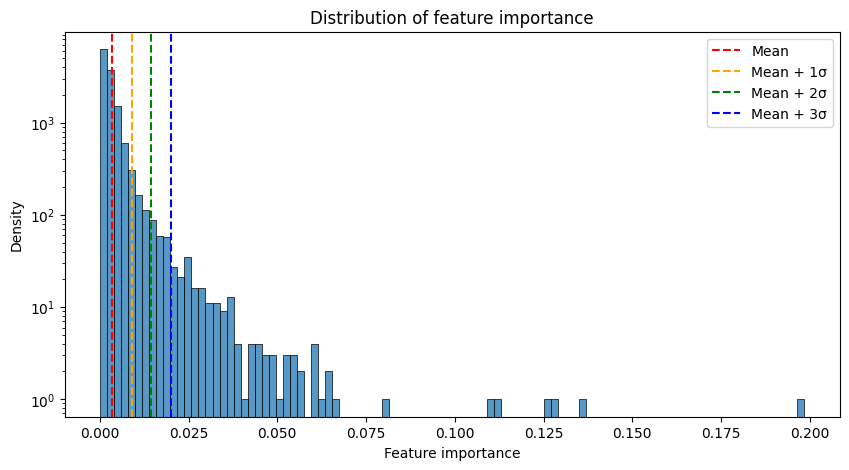

Numero di feature necessarie per raggiungere almeno l'80% dell'importanza cumulativa: 5580


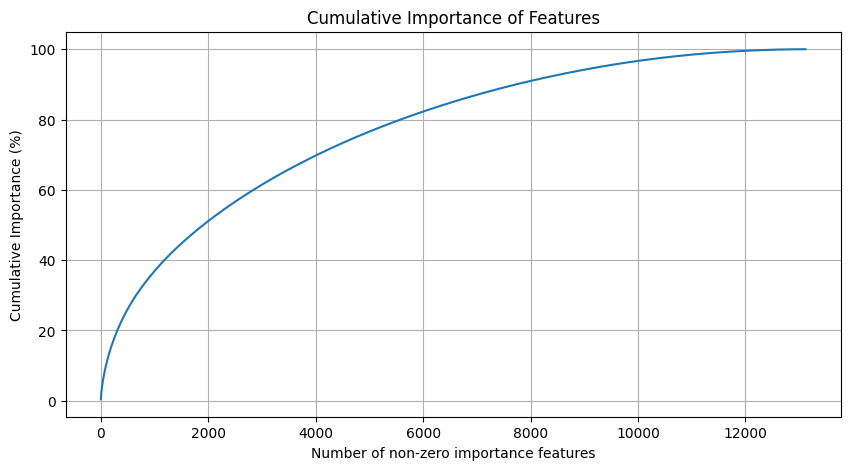

In [74]:
csf_CD4_explNonZero = csf_CD4_explanations[csf_CD4_explanations['MeanAbsoluteShap'] != 0]

csf_CD4SelectedFeatures, csf_CD4SigmaFeatures  = importanceAnalysis(csf_CD4_explNonZero, sigma=0)

In [79]:
csf_CD4_explNonZero_dict = dict(zip(csf_CD4_explNonZero['Feature'][:500], csf_CD4_explNonZero['MeanAbsoluteShap'][:500]))
# csf_CD4_explNonZero_dict = dict(zip(csf_CD4_explNonZero['Feature'][:csf_CD4SelectedFeatures], csf_CD4_explNonZero['MeanAbsoluteShap'][:csf_CD4SelectedFeatures]))
csf_CD4_cluster = joblib.load(path + "CD4_CSF_uniqueClusters.pkl")

csf_CD4_80_enriched = addGeneClusters(csf_CD4_explNonZero_dict, csf_CD4_cluster)

for gene in csf_CD4_explNonZero_dict.keys():
    if gene not in csf_CD4_80_enriched:
        print(f"{gene} not in csf_CD4_80_enriched")

print(len(csf_CD4_explNonZero_dict), "-->", len(csf_CD4_80_enriched))

500 --> 753


In [80]:
print(list(csf_B_80_enriched.keys()))

['CD300LD', 'LRRC8E', 'LINC00332', 'RPLP1', 'RPL41', 'RPS19', 'RPS12', 'RPL30', 'RPS3A', 'RPL7A', 'RPL22', 'FAU', 'RPS16', 'RPL19', 'RPL31', 'RPL13', 'RPL29', 'RPS20', 'RPL35A', 'RPL37A', 'RPL36', 'RPS11', 'RPL35', 'TOMM7', 'RPL18', 'RPL27A', 'RPS27A', 'RPL32', 'EEF1B2', 'PFDN5', 'RPLP2', 'RPS8', 'RPS25', 'RPL6', 'RPS17', 'RPL27', 'RPS6', 'RPS14', 'RPL37', 'RPL23', 'UBA52', 'RPL8', 'RPL11', 'RPL39', 'RPS13', 'RPS15', 'RPL28', 'RPL18A', 'RPL12', 'RPL23A', 'NACA', 'RPL21', 'RPL9', 'RPS23', 'RPS15A', 'RPL13A', 'RPL15', 'RPS24', 'RPL14', 'RPL26', 'RPL24', 'RPL34', 'RPL10', 'RPL38', 'RPS28', 'ACTN3', 'GATA3-AS1', 'LRRC10', 'TMEM74', 'ANO9', 'AMIGO3', 'PIK3R3', 'LAPTM5', 'KRTAP12-3', 'EIF1', 'LINC01209', 'MT-CO1', 'MTRNR2L8', 'MT-ND5', 'MT-CO3', 'MT-ND2', 'MT-CO2', 'MT-CYB', 'MT-ND4L', 'MT-ND3', 'MT-ND1', 'MT-ATP6', 'MT-ND4', 'MTRNR2L12', 'SLC4A9', 'DSG2-AS1', 'XKRX', 'TOX', 'FCGR2A', 'CXCL16', 'ADGRE2', 'P4HA1', 'SAT1', 'SUOX', 'SIRPA', 'CTSB', 'FGL2', 'PLXDC2', 'PLSCR1', 'ATP8B4', 'IFNGR2'

<h3>B cells PBMC</h3>

In [81]:
pbmc_B_explanations = joblib.load(path + "BCELLS_PBMC_EXPL.pkl")
pbmc_B_expl = dict(zip(pbmc_B_explanations["Feature"], pbmc_B_explanations["MeanAbsoluteShap"]))

for gene, importance in pbmc_B_expl.items():
    if gene in knownImportant and importance != 0:
        print(f"{gene}: {importance}, {pbmc_B_explanations[pbmc_B_explanations['Feature'] == gene].index}")

#Nessun gene noto nei 96 geni importanti in PBMC

Mean: 0.010805013303190109
Stadnard Deviation: 0.024997559985644333
Number of features over 0 sigma: 20 ['SLC30A4', 'APBB2', 'AGPAT5', 'YBX3', 'EPHX3', 'APLP2', 'TSPAN13', 'LGR5', 'IGFBP4', 'CD200', 'LINC01374', 'FAM228A', 'FCER2', 'ADORA2B', 'CENPT', 'GADD45A', 'TTTY14', 'AC017074.2', 'MUC12', 'LPXN']


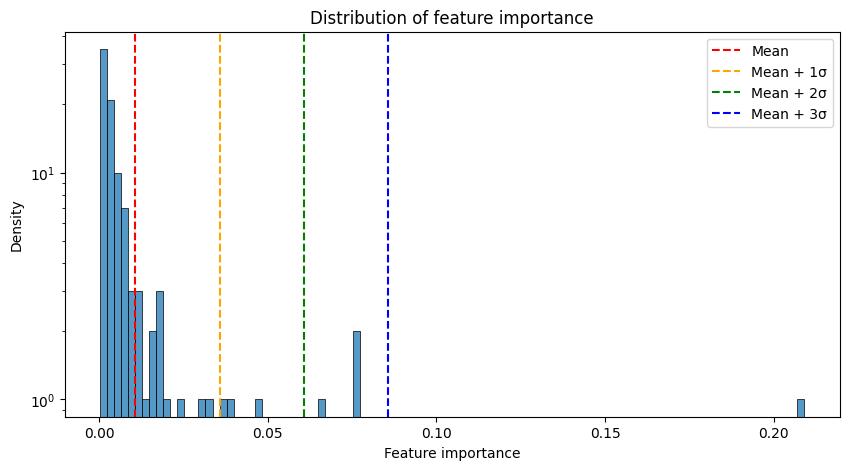

Numero di feature necessarie per raggiungere almeno l'80% dell'importanza cumulativa: 25


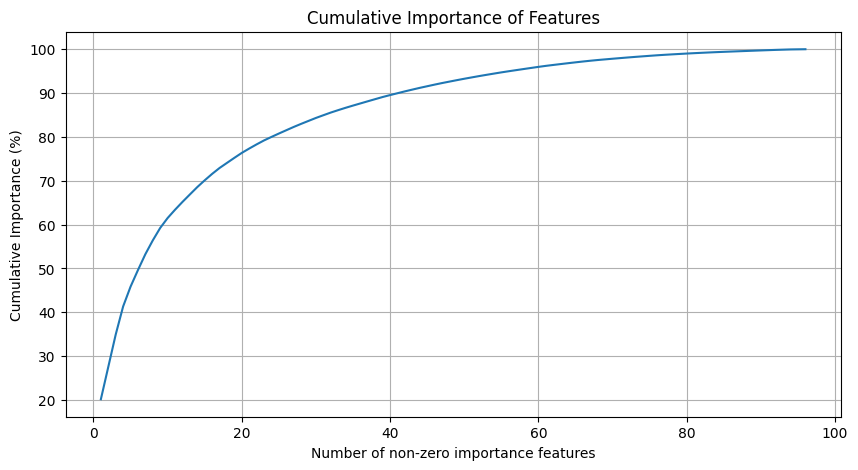

In [82]:
pbmc_B_explNonZero = pbmc_B_explanations[pbmc_B_explanations['MeanAbsoluteShap'] != 0]

pbmc_BSelectedFeatures, pbmc_BSigmaFeatures = importanceAnalysis(pbmc_B_explNonZero, sigma=0)

In [83]:
pbmc_B_explNonZero_dict = dict(zip(pbmc_B_explNonZero['Feature'][:500], pbmc_B_explNonZero['MeanAbsoluteShap'][:500]))
# pbmc_B_explNonZero_dict = dict(zip(pbmc_B_explNonZero['Feature'][:pbmc_BSelectedFeatures], pbmc_B_explNonZero['MeanAbsoluteShap'][:pbmc_BSelectedFeatures]))
pbmc_B_cluster = joblib.load(path + "BCELLS_PBMC_uniqueClusters.pkl")

pbmc_B_80_enriched = addGeneClusters(pbmc_B_explNonZero_dict, pbmc_B_cluster)

for gene in pbmc_B_explNonZero_dict.keys():
    if gene not in pbmc_B_80_enriched:
        print(f"{gene} not in pbmc_B_80_enriched")

print(len(pbmc_B_explNonZero_dict), "-->", len(pbmc_B_80_enriched))

96 --> 439


In [84]:
print(list(pbmc_B_80_enriched.keys()))

['SLC30A4', 'APBB2', 'IGHD', 'FCRL1', 'CORO2B', 'SNX29', 'RAB30', 'CAMK2D', 'IGHM', 'RRM2B', 'AGPAT5', 'ADARB1', 'BACH2', 'CD200', 'MMP17', 'TSPAN13', 'EPB41L2', 'COL19A1', 'NSUN7', 'ABCB4', 'APLP2', 'TAPT1', 'LIX1', 'CLCN4', 'ZDHHC19', 'YBX3', 'L3MBTL4', 'TCL1A', 'AL132709.8', 'TPST1', 'SERPINB9P1', 'BCL7A', 'CDCA7L', 'DBNDD1', 'DSP', 'IL4R', 'FCER2', 'FAM111B', 'TCL1B', 'ZNF318', 'ZHX3', 'TCTN1', 'SYT17', 'DTX4', 'MSMP', 'MACROD2', 'PDE7B', 'NETO1', 'P2RY14', 'LINC01104', 'ZNF667-AS1', 'ARHGAP32', 'EPHX3', 'LGR5', 'IGFBP4', 'LINC01415', 'LINC01374', 'FAM228A', 'ADORA2B', 'CENPT', 'GADD45A', 'TTTY14', 'AC017074.2', 'MUC12', 'LPXN', 'ST14', 'STAMBPL1', 'SIGLEC6', 'ACAP3', 'DGKG', 'PNMA5', 'TFEC', 'ACR', 'IHH', 'IFNGR2', 'CD37', 'SLC38A10', 'CNP', 'EDEM2', 'ELFN1-AS1', 'IGHV4-4', 'MLEC', 'ABCB9', 'IGHV3-41', 'WFDC2', 'TMEM198', 'PRDM1', 'PDIA6', 'AIFM2', 'IGHV3-66', 'CCDC110', 'WFDC10B', 'BIK', 'OGFOD2', 'UCHL1', 'TBL2', 'CEP97', 'IGHA1', 'SLC38A5', 'CHAC2', 'LBX2', 'SAR1B', 'IRF4', 'NU

<h2>Enrichment Analysis</h2>

<h3>WebGestalt Enrichment</h3>

In [85]:
def webGestaltEnrichment(geneList, pathwayDatabase, output_csv, background = None):
    """
    Esegue l'arricchimento WebGestalt per una lista di geni.
    
    Args:
        geneList (list): Lista di geni da arricchire.
        output_csv (str): Nome del file CSV di output.
        background (list, optional): Lista di geni di sfondo. Se None, non viene utilizzato alcun sfondo.
    """
    if background is None:
        background = []
        backgroundFlag = "0"  # No background
    else:
        backgroundFlag = "1" # Background provided

    with open("gene_list.json", "w") as f:
        json.dump(geneList, f)

    with open("background.json", "w") as f:
        json.dump(background, f)

    if not os.path.exists("webGestaltScript.R"):
        raise FileNotFoundError("Il file webGestaltScript.R non è stato trovato.")
        

    # Esegui il comando R
    cmd = [
        "Rscript", "webGestaltScript.R",
        pathwayDatabase,
        "gene_list.json",
        "ORA",           # enrichmentMethod
        "hsapiens",      # organism
        backgroundFlag,  # backgroundFlag
        "background.json",  # referenceSet 
        "genesymbol",    # interestGeneType
        "BH",            # fdrMethod
        "0.05",          # fdrThr
        "5",             # minNum
        "2000",          # maxNum
        "2",             # nThreads
        output_csv       # outputCsvFile
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)

    print("STDOUT:")
    print(result.stdout)

    if result.returncode != 0:
        print(f"Errore R (code {result.returncode})")
        return

    if not os.path.exists(output_csv):
        print(f"Il file {output_csv} non è stato creato.")
        return

    df = pd.read_csv(output_csv, index_col=0)
    new_df = pd.DataFrame(columns=df.index)
    for index, row in df.iterrows():
        list_Splitted = row.values[0].split("|")
        new_df[index] = list_Splitted

    new_df.to_csv(output_csv)

In [ ]:
#ESEMPIO
#background = list(pd.read_csv("../../SYMBOL/Dataset/MergedDatasetFullCombat_symbol.csv").columns[2:])
#pathway_KEGG  o pathway_Reactome
#webGestaltEnrichment(list(microarray_80_enriched.keys()), "pathway_KEGG", "microarray_Full_WGES+BCKG_enriched.csv")

<h3>StringDB Enrichment</h3>

In [86]:
background = list(pd.read_csv("../../SYMBOL/Dataset/MergedDatasetFullCombat_symbol.csv").columns[2:])

def stringDbEnrichment(geneList, pathwayDatabase, scoreTreshold, output_csv, background = None):
    """
    Esegue l'arricchimento WebGestalt per una lista di geni.
    
    Args:
        geneList (list): Lista di geni da arricchire.
        output_csv (str): Nome del file CSV di output.
        background (list, optional): Lista di geni di sfondo. Se None, non viene utilizzato alcun sfondo.
    """

    if background is None:
        background = []
        backgroundFlag = "0"  # No background
    else:
        backgroundFlag = "1" # Background provided

    with open("gene_list.json", "w") as f:
        json.dump(geneList, f)

    with open("background.json", "w") as f:
        json.dump(background, f)

    if not os.path.exists("webGestaltScript.R"):
        raise FileNotFoundError("Il file webGestaltScript.R non è stato trovato.")
        
    # Esegui il comando R
    cmd = [
        "Rscript", "stringDBScript.R",
        pathwayDatabase,
        "gene_list.json",
        backgroundFlag,  # backgroundFlag
        "background.json",  # referenceSet 
        str(scoreTreshold),    # scoreTreshold
        output_csv       # outputCsvFile
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)

    print("STDOUT:")
    print(result.stdout)

    if result.returncode != 0:
        print(f"Errore R (code {result.returncode})")
        return

    if not os.path.exists(output_csv):
        print(f"Il file {output_csv} non è stato creato.")
        return

In [ ]:
#ESEMPIO
#KEGG o RCTM
# stringDbEnrichment(list(microarray_80_enriched.keys()), "KEGG", 400, "microarray_Full_STRING_enriched.csv")

In [87]:
path = "../../Enrichment/"

In [18]:
xaiSummary = pd.read_csv("../../../xai_summary.csv", index_col=0)
xaiSummary.columns = ['microarray', 'CSF_B_NoCluster', 'CSF_B_Cluster', 'CSF_B_80Cluster', 'PBMC_B_NoCluster', 'PBMC_B_Cluster', 'PBMC_B_80Cluster', 'CSF_CD4_80NoCluster', 'CSF_CD4_80Cluster', 'PBMC_B_80NoCluster']
xaiSummary = xaiSummary[['microarray', 'CSF_B_NoCluster', 'CSF_B_Cluster', 'CSF_B_80Cluster', 'PBMC_B_NoCluster', 'PBMC_B_Cluster', 'PBMC_B_80NoCluster', 'PBMC_B_80Cluster', 'CSF_CD4_80NoCluster', 'CSF_CD4_80Cluster']]

In [19]:
xaiSummary

microarray  CSF_B_NoCluster  CSF_B_Cluster  CSF_B_80Cluster  \
UBE2D2              0                0              1                1   
FNDC3B              0                0              0                0   
DYNC1I2             1                0              0                0   
SNX1                0                0              1                1   
LINC00269           0                0              0                0   
...               ...              ...            ...              ...   
NDFIP1              0                0              1                1   
MMP16               0                0              1                1   
TNPO1               0                0              1                1   
RNASE10             0                1              1                0   
PGAP1               0                0              0                0   

           PBMC_B_NoCluster  PBMC_B_Cluster  PBMC_B_80NoCluster  \
UBE2D2                    0               0                   0   
FNDC3B                    0               1                   0   
DYNC1I2                   0               0                   0   
SNX1                      0               0                   0   
LINC00269                 0               0                   0   
...                     ...             ...                 ...   
NDFIP1                    0               0                   0   
MMP16                     0               0                   0   
TNPO1                     0               0                   0   
RNASE10                   0               0                   0   
PGAP1                     0               0                   0   

           PBMC_B_80Cluster  CSF_CD4_80NoCluster  CSF_CD4_80Cluster  
UBE2D2                    0                    0                  0  
FNDC3B                    1                    0                  0  
DYNC1I2                   0                    0                  0  
SNX1                      0                    0                  0  
LINC00269                 0                    1                  1  
...                     ...                  ...                ...  
NDFIP1                    0                    0                  0  
MMP16                     0                    1                  1  
TNPO1                     0                    0                  0  
RNASE10                   0                    1                  1  
PGAP1                     0                    1                  1  

[12637 rows x 10 columns]

In [20]:
print(xaiSummary.sum())

microarray              724
CSF_B_NoCluster        3073
CSF_B_Cluster          7718
CSF_B_80Cluster        4916
PBMC_B_NoCluster         96
PBMC_B_Cluster         2201
PBMC_B_80NoCluster       25
PBMC_B_80Cluster       2052
CSF_CD4_80NoCluster    6000
CSF_CD4_80Cluster      6416
dtype: int64


In [21]:
print(list(xaiSummary[xaiSummary['CSF_CD4_80Cluster'] == 1][['CSF_CD4_80Cluster']].index.values))

['LINC00269', 'RHOT2', 'ZNF383', 'DHX9', 'LANCL3', 'TMEM233', 'CKMT2-AS1', 'TTC16', 'C6orf99', 'AC098617.1', 'TMEM254-AS1', 'NEDD4L', 'AC073987.1', 'MTRNR2L1', 'TCEAL2', 'CCPG1', 'HNRNPM', 'ZNF385B', 'GPER1', 'PLD3', 'OTUB2', 'FCRL4', 'CDC42SE2', 'NOXA1', 'DNAJB5', 'FMO2', 'NOVA2', 'TRIM45', 'TRBV10-2', 'ZNF527', 'MYBBP1A', 'STEAP1B', 'DCAF4L2', 'ACADSB', 'MLXIP', 'EFCAB7', 'XRN2', 'TMEM204', 'CXorf58', 'MLIP', 'TMEM186', 'CHRNE', 'SFT2D3', 'ACIN1', 'MSX2', 'POLD3', 'BEX5', 'PGS1', 'PCDHA9', 'KAAG1', 'SMIM17', 'B3GNT6', 'RAB8B', 'FITM2', 'SLC7A1', 'RASL11B', 'TRBV21-1', 'FUBP1', 'SNX25', 'IGHEP1', 'PHC2', 'PCSK6-AS1', 'PIH1D2', 'LIPE', 'KIAA1614', 'LYVE1', 'SLC7A6', 'NDUFA3', 'FCMR', 'RASSF1', 'PPP1R32', 'AC003005.2', 'PEAR1', 'VNN1', 'IGKC', 'LOR', 'RHOXF2B', 'ATPAF2', 'GSPT1', 'LINC01088', 'SLC39A4', 'CDYL2', 'LINC00488', 'CD36', 'CNN3', 'UBE2E2', 'MSTN', 'ZNF460', 'CAPS', 'OGFRL1', 'TMPRSS12', 'RPL12', 'RGL1', 'ZNRF1', 'TCOF1', 'TTC30B', 'DOK5', 'PNPLA3', 'NUP50', 'TIE1', 'LENEP', '

<h2>KEGG Enrichment</h2>

In [22]:
microarray_Full_kegg = pd.read_csv(path+"MicroarrayFull_enrichment_KEGG.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]
csf_B_80Cluster_kegg = pd.read_csv(path+"CSF_Bcells80Cluster_enrichment_KEGG.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]
pbmc_B_FullCluster_kegg = pd.read_csv(path+"PBMC_BcellsFullCluster_enrichment_KEGG.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]
csf_CD4_80Cluster_kegg = pd.read_csv(path+"CSF_CD480Cluster_enrichment_KEGG.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]

In [23]:
csf_B_80Cluster_kegg

# background genes  # genes  \
0                 131       57   
1                  90       15   
2                  85       15   
3                  37       10   
4                  99       15   
5                  87       13   

                                         description     FDR value  \
0                                           Ribosome  2.660000e-29   
1                         Hematopoietic cell lineage  6.000000e-03   
2                   Th1 and Th2 cell differentiation  6.000000e-03   
3                           Primary immunodeficiency  6.000000e-03   
4                          Th17 cell differentiation  1.180000e-02   
5  PD-L1 expression and PD-1 checkpoint pathway i...  2.930000e-02   

                                               genes       p-value  \
0  RPL18A|RPL19|RPS12|RPL35|RSL24D1|RPL8|RPS11|RP...  7.920000e-32   
1  CD4|CD22|FCER2|CSF1R|CD3D|IL7R|CD19|CD3E|CD2|M...  6.820000e-05   
2  CD4|IL2RB|PRKCQ|CD3D|MAF|RBPJ|CD3E|CD247|IL2RG...  3.820000e-05   
3  CD4|CD79A|TNFRSF13B|TNFRSF13C|CD3D|IL7R|CD19|C...  3.580000e-05   
4  CD4|IL2RB|PRKCQ|CD3D|CD3E|CD247|IL2RG|FOXP3|IL...  1.800000e-04   
5  CD4|TLR2|PIK3R3|PRKCQ|CD3D|RASGRP1|CD3E|CD247|...  5.200000e-04   

   transferred FDR value  
0               2.857512  
1               0.222185  
2               0.222185  
3               0.222185  
4               0.192812  
5               0.153313

<h3>Trovo l'unione di tutti i pathway</h3>

In [24]:
all_pathways_kegg = set(microarray_Full_kegg['description']) | set(csf_B_80Cluster_kegg['description']) | set(pbmc_B_FullCluster_kegg['description']) | set(csf_CD4_80Cluster_kegg['description'])
all_pathways_kegg

{'Adherens junction',
 'Alzheimer disease',
 'Apoptosis',
 'Cell cycle',
 'Chronic myeloid leukemia',
 'Epstein-Barr virus infection',
 'Hematopoietic cell lineage',
 'Hepatitis C',
 'Human cytomegalovirus infection',
 'Human immunodeficiency virus 1 infection',
 'Influenza A',
 'Measles',
 'Metabolic pathways',
 'Mitophagy - animal',
 'N-Glycan biosynthesis',
 'NOD-like receptor signaling pathway',
 'Necroptosis',
 'PD-L1 expression and PD-1 checkpoint pathway in cancer',
 'Primary immunodeficiency',
 'Protein processing in endoplasmic reticulum',
 'Ribosome',
 'Salmonella infection',
 'Shigellosis',
 'Sphingolipid signaling pathway',
 'T cell receptor signaling pathway',
 'Th1 and Th2 cell differentiation',
 'Th17 cell differentiation',
 'Ubiquitin mediated proteolysis',
 'Various types of N-glycan biosynthesis',
 'Viral carcinogenesis',
 'Viral myocarditis',
 'Yersinia infection'}

In [25]:
len(list(all_pathways_kegg))

32

<h4>Nota: i vari file hanno associato al pathway solo i geni di quella rete che fanno parte di quel pathway</h4>

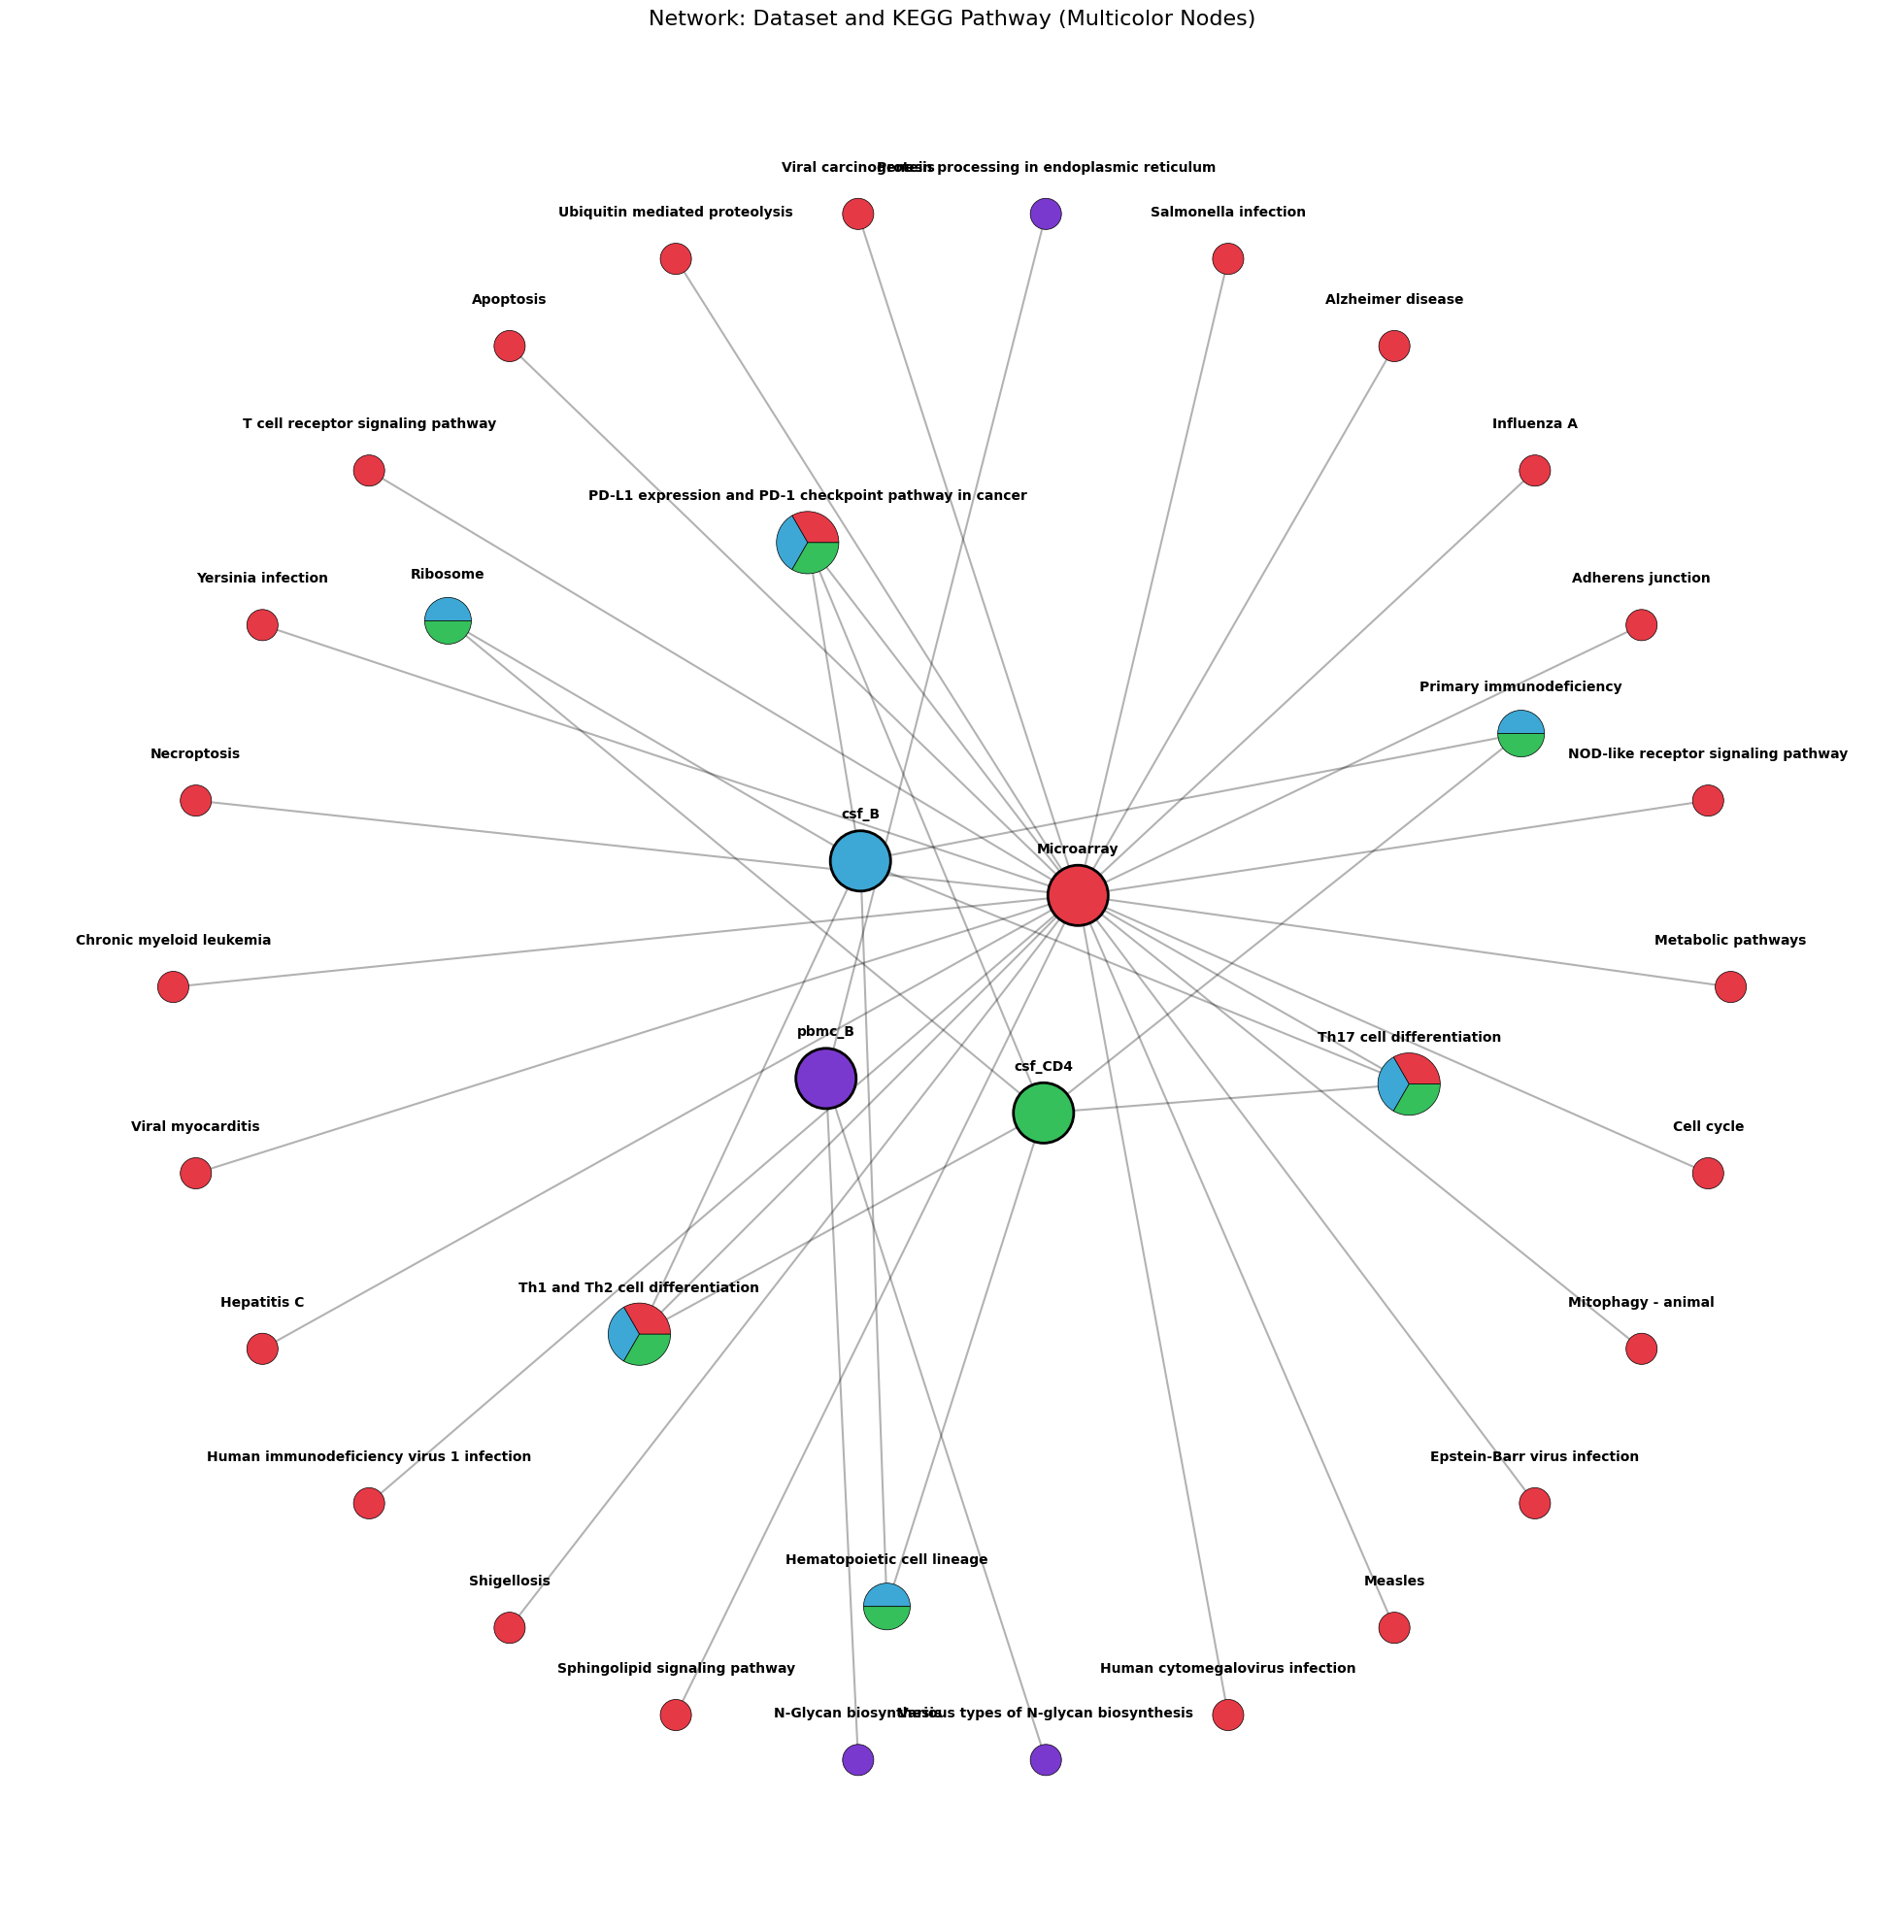

In [26]:
G = nx.Graph()

# Definizione nodi
dataset_nodes = ['Microarray', 'csf_B', 'pbmc_B', 'csf_CD4']
G.add_nodes_from(dataset_nodes, bipartite=0)
G.add_nodes_from(all_pathways_kegg, bipartite=1)

# Aggiunta archi
for pathway in microarray_Full_kegg['description']:
    if pathway in all_pathways_kegg:
        G.add_edge('Microarray', pathway)

for pathway in csf_B_80Cluster_kegg['description']:
    if pathway in all_pathways_kegg:
        G.add_edge('csf_B', pathway)

for pathway in pbmc_B_FullCluster_kegg['description']:
    if pathway in all_pathways_kegg:
        G.add_edge('pbmc_B', pathway)

for pathway in csf_CD4_80Cluster_kegg['description']:
    if pathway in all_pathways_kegg:
        G.add_edge('csf_CD4', pathway)

# -------------------------------
# POSIZIONAMENTO (shell_layout)
# -------------------------------

# Conta le connessioni di ciascun pathway ai dataset
pathway_dataset_count = {p: 0 for p in all_pathways_kegg}
for dataset in dataset_nodes:
    for neighbor in G.neighbors(dataset):
        if neighbor in all_pathways_kegg:
            pathway_dataset_count[neighbor] += 1

# Crea cerchi concentrici
pathway_circles = {i: [] for i in range(1, 5)}
for pathway, count in pathway_dataset_count.items():
    pathway_circles[count].append(pathway)

shells = [
    dataset_nodes,
    pathway_circles[4],
    pathway_circles[3],
    pathway_circles[2],
    pathway_circles[1],
]

pos = nx.shell_layout(G, shells)

# -------------------------------
# VISUALIZZAZIONE
# -------------------------------

# Colori per dataset
dataset_color_map = {
    'Microarray': '#E63946',
    'csf_B': "#3DA8D5",
    'pbmc_B': "#7A39CE",
    'csf_CD4': "#35C05C"
}

dataset_colors = [dataset_color_map[d] for d in dataset_nodes]

# Crea figura
plt.figure(figsize=(20, 20))
ax = plt.gca()
ax.set_aspect('equal')

# Disegna nodi dataset
nx.draw_networkx_nodes(
    G, pos,
    nodelist=dataset_nodes,
    node_color=dataset_colors,
    node_size=2000,
    edgecolors='black',
    linewidths=2
)

# Disegna archi (neri)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    edge_color='black',
    width=1.5,
    alpha=0.3
)

# Crea una mappa semplice: dimensione del nodo PATHWAY in base al numero di dataset connessi
radius_map = {4: 0.045, 3: 0.04, 2: 0.03, 1: 0.02}  # valori testabili

for pathway in all_pathways_kegg:
    x, y = pos[pathway]
    connected = [d for d in dataset_nodes if G.has_edge(d, pathway)]
    num = len(connected)
    radius = radius_map[num]  # raggio fisso in coordinate del grafo
    angle = 360 / num
    for i, d in enumerate(connected):
        wedge = Wedge(center=(x, y), r=radius,
                      theta1=i*angle, theta2=(i+1)*angle,
                      facecolor=dataset_color_map[d],
                      edgecolor='black', linewidth=0.5)
        ax.add_patch(wedge)

# Etichette
label_pos = {k: (v[0], v[1] + 0.06) for k, v in pos.items()}
nx.draw_networkx_labels(
    G, 
    label_pos,
    labels={n: n for n in dataset_nodes + list(all_pathways_kegg)},
    font_size=10,
    font_family='sans-serif',
    font_weight='bold',
    verticalalignment='center',
    horizontalalignment='center'
)

# Titolo e visualizzazione
plt.title("Network: Dataset and KEGG Pathway (Multicolor Nodes)", fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

<h4>Creo un dizionario con come chiavi i pathway e come valori tutti i geni tra le varie reti associati a quel pathway</h4>

In [27]:
def extract_genes(df, pathway):
    row = df[df['description'] == pathway]
    if not row.empty:
        return set(row['genes'].values[0].split('|'))
    return set()

dataframes_kegg = [
    microarray_Full_kegg,
    csf_B_80Cluster_kegg,
    pbmc_B_FullCluster_kegg,
    csf_CD4_80Cluster_kegg
]

all_pathDict_kegg = {}
for pathway in all_pathways_kegg:
    genes = set()
    for df in dataframes_kegg:
        extracted = extract_genes(df, pathway)
        genes |= extracted
    if genes:
        all_pathDict_kegg[pathway] = list(genes)

all_pathDict_kegg

{'Chronic myeloid leukemia': ['CRKL',
  'NFKBIA',
  'CDKN1B',
  'MDM2',
  'CHUK',
  'KRAS',
  'STAT5A',
  'CCND1',
  'ABL1'],
 'Viral myocarditis': ['CASP8',
  'ACTB',
  'BID',
  'CYCS',
  'CD40LG',
  'CCND1',
  'HLA-DRB5',
  'CD28',
  'EIF4G1',
  'ABL1'],
 'Ribosome': ['UBA52',
  'RPL38',
  'RPS8',
  'RPL19',
  'RPL6',
  'RPS20',
  'RPL10',
  'FAU',
  'RPS27A',
  'RPS15A',
  'RPLP2',
  'RPL23A',
  'RPS6',
  'RPL35A',
  'RPL39',
  'RPL37A',
  'RPL13',
  'RPL22',
  'RPL27A',
  'RSL24D1',
  'RPL32',
  'RPL21',
  'RPL18A',
  'RPL24',
  'RPL14',
  'RPL30',
  'RPS14',
  'RPL26',
  'RPL8',
  'RPS19',
  'RPL23',
  'RPL18',
  'RPS23',
  'RPL12',
  'RPS15',
  'RPL29',
  'RPS13',
  'RPL15',
  'RPL28',
  'RPL34',
  'RPL7A',
  'RPS11',
  'RPL31',
  'RPS12',
  'RPS3A',
  'RPLP1',
  'RPS28',
  'RPS17',
  'RPL9',
  'RPL37',
  'RPL13A',
  'RPL11',
  'RPL35',
  'RPL27',
  'RPS24',
  'RPS25',
  'RPL36'],
 'Hepatitis C': ['PPP2R1A',
  'NFKBIA',
  'PPP2R2A',
  'CHUK',
  'CYCS',
  'JAK1',
  'PPP2CB',
  'TB

<h4>Calcolo l'importanza nel processo decisionale di ogni pathway sommando le importanze SHAP di ogni gene che lo compone</h4>

In [28]:
expl_sorted = joblib.load("../../../SYMBOL/Results/DatasetFull/xgbDefFull_explSorted.pkl")

In [29]:
def makePathImportance(pathDict, pathways, expl):
    pathImportance = {}
    for pathway, geneList in pathDict.items():
        pathImportance[pathway] = 0
        if pathway in pathways:
            for gene in geneList:
                if gene in expl:
                    pathImportance[pathway] += expl[gene]
    return {k: v for k, v in sorted(pathImportance.items(), key=lambda item: item[1], reverse=True)}

microarray_pathImportance = makePathImportance(all_pathDict_kegg, microarray_Full_kegg['description'].values, expl_sorted)
microarray_pathImportance

{'Metabolic pathways': 1.9258015954977357,
 'Alzheimer disease': 0.9999182707764718,
 'Viral carcinogenesis': 0.5438438316388922,
 'Epstein-Barr virus infection': 0.5277364402789494,
 'Ubiquitin mediated proteolysis': 0.5080923968159474,
 'Necroptosis': 0.48457233530687543,
 'Measles': 0.48338343634947517,
 'Influenza A': 0.47830693920432743,
 'Viral myocarditis': 0.47074338410080624,
 'Hepatitis C': 0.460199008580538,
 'Sphingolipid signaling pathway': 0.45804720429347145,
 'Salmonella infection': 0.4495086420016797,
 'Adherens junction': 0.37542194290443404,
 'Human immunodeficiency virus 1 infection': 0.3645098558709159,
 'Th17 cell differentiation': 0.35647475016927793,
 'T cell receptor signaling pathway': 0.3245351413236845,
 'NOD-like receptor signaling pathway': 0.32247354679551643,
 'Shigellosis': 0.31731888213494375,
 'Th1 and Th2 cell differentiation': 0.3154912998480093,
 'Human cytomegalovirus infection': 0.31332309248639123,
 'Yersinia infection': 0.2681323477343563,
 'PD

<h3>Seleziono alcuni pathway che hanno un ruolo nella malattia</h3>

In [30]:
pathwaysOfInterest_kegg = ['Alzheimer disease', 'Parkinson disease', 'Apoptosis', 'B cell receptor signaling pathway', 'Chemokine signaling pathway', 'Epstein-Barr virus infection', 'NOD-like receptor signaling pathway', 'Necroptosis', 'T cell receptor signaling pathway', 'Th1 and Th2 cell differentiation', 'Th17 cell differentiation']

In [31]:
microarray_Full_kegg[microarray_Full_kegg['description'].isin(pathwaysOfInterest_kegg)]

# background genes  # genes                          description  \
1                  147       18                          Necroptosis   
4                  173       18  NOD-like receptor signaling pathway   
9                  100       12    T cell receptor signaling pathway   
10                 354       27                    Alzheimer disease   
12                 192       18         Epstein-Barr virus infection   
18                 131       13                            Apoptosis   
19                  85       10     Th1 and Th2 cell differentiation   
20                  99       11            Th17 cell differentiation   

    FDR value                                              genes   p-value  \
1      0.0035  EIF2AK2|IL1B|FTH1|GLUD1|SPATA2L|H2AC8|GLUL|BID...  0.000021   
4      0.0093  NFKBIA|NAMPT|CCL2|PANX1|IL1B|YWHAE|NOD2|TBK1|P...  0.000140   
9      0.0180  CD4|NFKBIA|NCK2|PPP3R1|KRAS|CD28|CHUK|CD40LG|P...  0.000570   
10     0.0180  PSMC4|CSNK2A1|EIF2AK2|PPP3R1|LRP1|KRAS|CSNK2A2...  0.000460   
12     0.0180  PSMC4|NFKBIA|CCND1|CDKN1B|EIF2AK2|MDM2|CCNE1|C...  0.000450   
18     0.0296  NFKBIA|KRAS|CTSK|EIF2AK3|CYCS|BID|TRADD|CASP8|...  0.001700   
19     0.0296  CD4|NFKBIA|PPP3R1|STAT5A|CHUK|HLA-DRB5|IL2RA|R...  0.001800   
20     0.0296  CD4|NFKBIA|PPP3R1|RARA|IL1B|STAT5A|CHUK|HSP90A...  0.001700   

    transferred FDR value  
1                0.245593  
4                0.203152  
9                0.174473  
10               0.174473  
12               0.174473  
18               0.152871  
19               0.152871  
20               0.152871

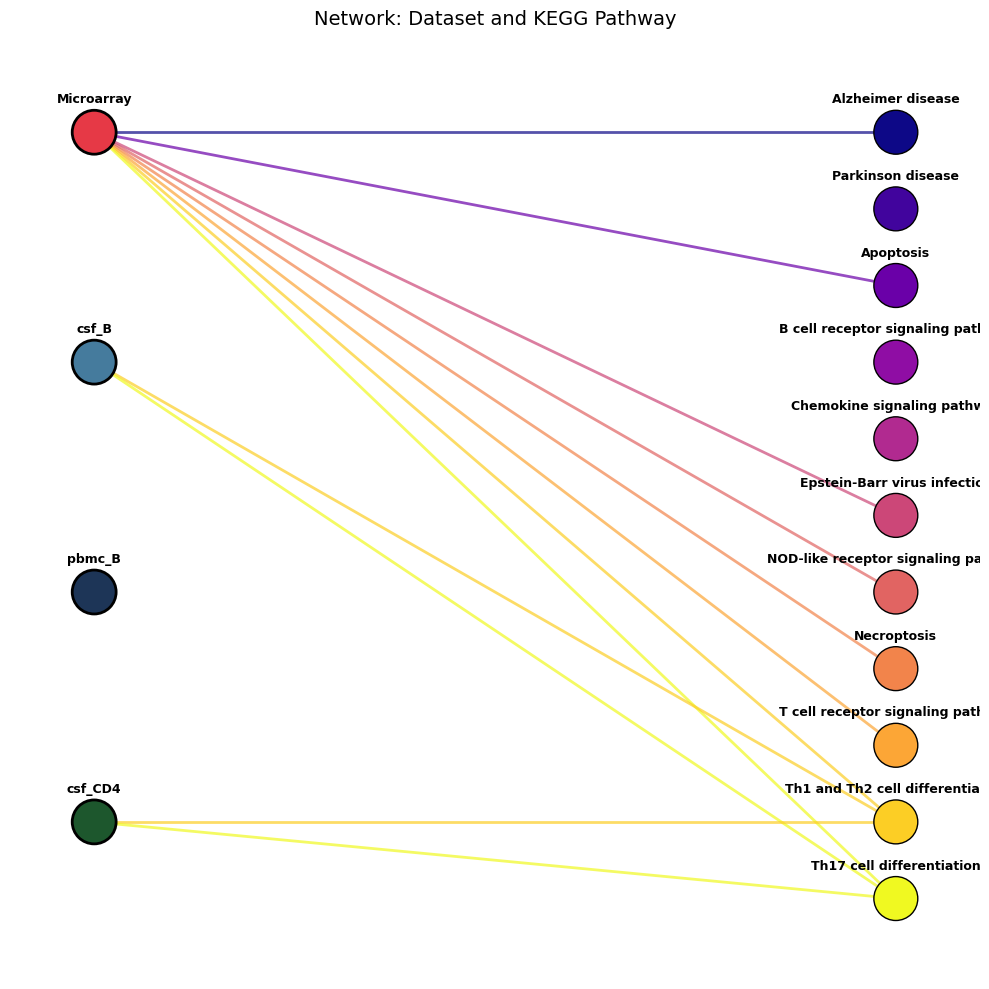

In [32]:
# Inizializzazione grafo
G = nx.Graph()

# Definizione nodi
dataset_nodes = ['Microarray', 'csf_B', 'pbmc_B', 'csf_CD4']
G.add_nodes_from(dataset_nodes, bipartite=0)
G.add_nodes_from(pathwaysOfInterest_kegg, bipartite=1)

# Aggiunta archi con controllo pathway
for pathway in microarray_Full_kegg['description']:
    if pathway in pathwaysOfInterest_kegg:
        G.add_edge('Microarray', pathway)

for pathway in csf_B_80Cluster_kegg['description']:
    if pathway in pathwaysOfInterest_kegg:
        G.add_edge('csf_B', pathway)

for pathway in pbmc_B_FullCluster_kegg['description']:
    if pathway in pathwaysOfInterest_kegg:
        G.add_edge('pbmc_B', pathway)

for pathway in csf_CD4_80Cluster_kegg['description']:
    if pathway in pathwaysOfInterest_kegg:
        G.add_edge('csf_CD4', pathway)

# Posizionamento nodi
pos = {}
dataset_colors = ['#E63946', '#457B9D', '#1D3557', "#1D572D"]  # Rosso, blu, blu scuro

# Posizione dataset (sinistra)
for i, node in enumerate(dataset_nodes):
    pos[node] = (0, -i * 60)

# Posizione pathway (destra)
for i, node in enumerate(pathwaysOfInterest_kegg):
    pos[node] = (3, -i * 20)  # Aumentato spazio orizzontale

# Palette vivaci per pathway (viridis, plasma, inferno, magma)
pathway_colors = plt.cm.plasma(np.linspace(0, 1, len(pathwaysOfInterest_kegg)))
pathway_color_dict = {pathway: pathway_colors[i] for i, pathway in enumerate(pathwaysOfInterest_kegg)}

# Creazione figura
plt.figure(figsize=(10, 10))

# Disegno nodi dataset
nx.draw_networkx_nodes(
    G, pos,
    nodelist=dataset_nodes,
    node_color=dataset_colors,
    node_size=1000,
    edgecolors='black',
    linewidths=2
)

# Disegno nodi pathway
nx.draw_networkx_nodes(
    G, pos,
    nodelist=pathwaysOfInterest_kegg,
    node_color=[pathway_color_dict[pathway] for pathway in pathwaysOfInterest_kegg],
    node_size=1000,
    edgecolors='black',
    linewidths=1
)

# Disegno archi colorati
for u, v in G.edges():
    pathway = v if u in dataset_nodes else u
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=pathway_color_dict[pathway],
        width=2,
        alpha=0.7
    )

label_pos = {k: (v[0], v[1] + 7) for k, v in pos.items() if k in pathwaysOfInterest_kegg+dataset_nodes}  # Sposta y +0.3

nx.draw_networkx_labels(
    G, 
    label_pos,  # Usa le nuove coordinate
    labels={n: n for n in pathwaysOfInterest_kegg+dataset_nodes},  # Solo pathway
    font_size=9,
    font_family='sans-serif',
    font_weight='bold',
    verticalalignment='bottom',  # Allinea il testo sotto alla posizione (quindi apparirà sopra il nodo)
    horizontalalignment='center'  # Centra orizzontalmente
)

# Titolo e layout
plt.title("Network: Dataset and KEGG Pathway", fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

<h2>REACTOME Enrichment</h2>

In [33]:
microarray_Full_rctm = pd.read_csv(path+"MicroarrayFull_enrichment_RCTM.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]
csf_B_80Cluster_rctm = pd.read_csv(path+"CSF_Bcells80Cluster_enrichment_RCTM.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]
pbmc_B_FullCluster_rctm = pd.read_csv(path+"PBMC_BcellsFullCluster_enrichment_RCTM.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]
csf_CD4_80Cluster_rctm = pd.read_csv(path+"CSF_CD480Cluster_enrichment_RCTM.csv")[['# background genes', '# genes', 'description', 'FDR value', 'genes', 'p-value', 'transferred FDR value']]

In [34]:
set(microarray_Full_rctm['description']) & set(csf_B_80Cluster_rctm['description']) & set(pbmc_B_FullCluster_rctm['description']) & set(csf_CD4_80Cluster_rctm['description'])

set()

In [35]:
all_pathways_rctm = set(microarray_Full_rctm['description']) | set(csf_B_80Cluster_rctm['description']) | set(pbmc_B_FullCluster_rctm['description']) | set(csf_CD4_80Cluster_rctm['description'])
all_pathways_rctm

{'Adaptive Immune System',
 'Asparagine N-linked glycosylation',
 'Axon guidance',
 'Biosynthesis of the N-glycan precursor (dolichol lipid-linked oligosaccharide, LLO) and transfer to a nascent protein',
 'C-type lectin receptors (CLRs)',
 'COPII-mediated vesicle transport',
 'Cap-dependent Translation Initiation',
 'Cargo concentration in the ER',
 'Cell Cycle',
 'Cell Cycle, Mitotic',
 'Cellular Senescence',
 'Cellular response to chemical stress',
 'Cellular responses to stimuli',
 'Cellular responses to stress',
 'Costimulation by the CD28 family',
 'Cyclin D associated events in G1',
 'Cytokine Signaling in Immune system',
 'DARPP-32 events',
 'DNA Repair',
 'Developmental Biology',
 'Disease',
 'Diseases of signal transduction by growth factor receptors and second messengers',
 'Downstream TCR signaling',
 'ER Quality Control Compartment (ERQC)',
 'ESR-mediated signaling',
 'Estrogen-dependent gene expression',
 'Eukaryotic Translation Elongation',
 'Eukaryotic Translation Termi

In [36]:
len(list(all_pathways_rctm))

93

In [37]:
pathwaysOfInterest_rctm = [
    'Activation of NF-kappaB in B cells', 
    'Adaptive Immune System', 'Immune System', 'Innate Immune System',
    'TCR signaling', 'Downstream TCR signaling',
    'Downstream signaling events of B Cell Receptor (BCR)',
    'Antigen Presentation: Folding, assembly and peptide loading of class I MHC', 'MHC class II antigen presentation',
    'Cytokine Signaling in Immune system',
    'Interleukin-1 signaling', 'Interleukin-1 family signaling',
    'TNF signaling',
    'FCERI mediated NF-kB activation', 'TNFR1-induced NFkappaB signaling pathway', 'TNFR2 non-canonical NF-kB pathway', 'TRAF6 mediated induction of NFkB and MAP kinases upon TLR7/8 or 9 activation', 'NIK-->noncanonical NF-kB signaling',
    'Toll Like Receptor 3 (TLR3) Cascade', 'Toll Like Receptor 4 (TLR4) Cascade', 'Toll Like Receptor 7/8 (TLR7/8) Cascade', 'Toll Like Receptor 9 (TLR9) Cascade', 'Toll-like Receptor Cascades',
    'Apoptosis', 'Programmed Cell Death', 'Regulation of Apoptosis',
    'Autophagy', 
    'Detoxification of Reactive Oxygen Species', 'Cellular responses to stress',
    'Axon guidance', 
    'Dectin-1 mediated noncanonical NF-kB signaling', 
    'Deregulated CDK5 triggers multiple neurodegenerative pathways in Alzheimers disease models', 
    'Downstream signaling events of B Cell Receptor (BCR)', 
    'Signaling by WNT', 'TCF dependent signaling in response to WNT',
    'Neutrophil degranulation']

#Controllare:
#ABC-Family Proteins Mediated Transport
#APC/C-Mediated Degradation of Cell Cycle Proteins
#APC/C:Cdc20 Mediated Degradation of Mitotic Proteins

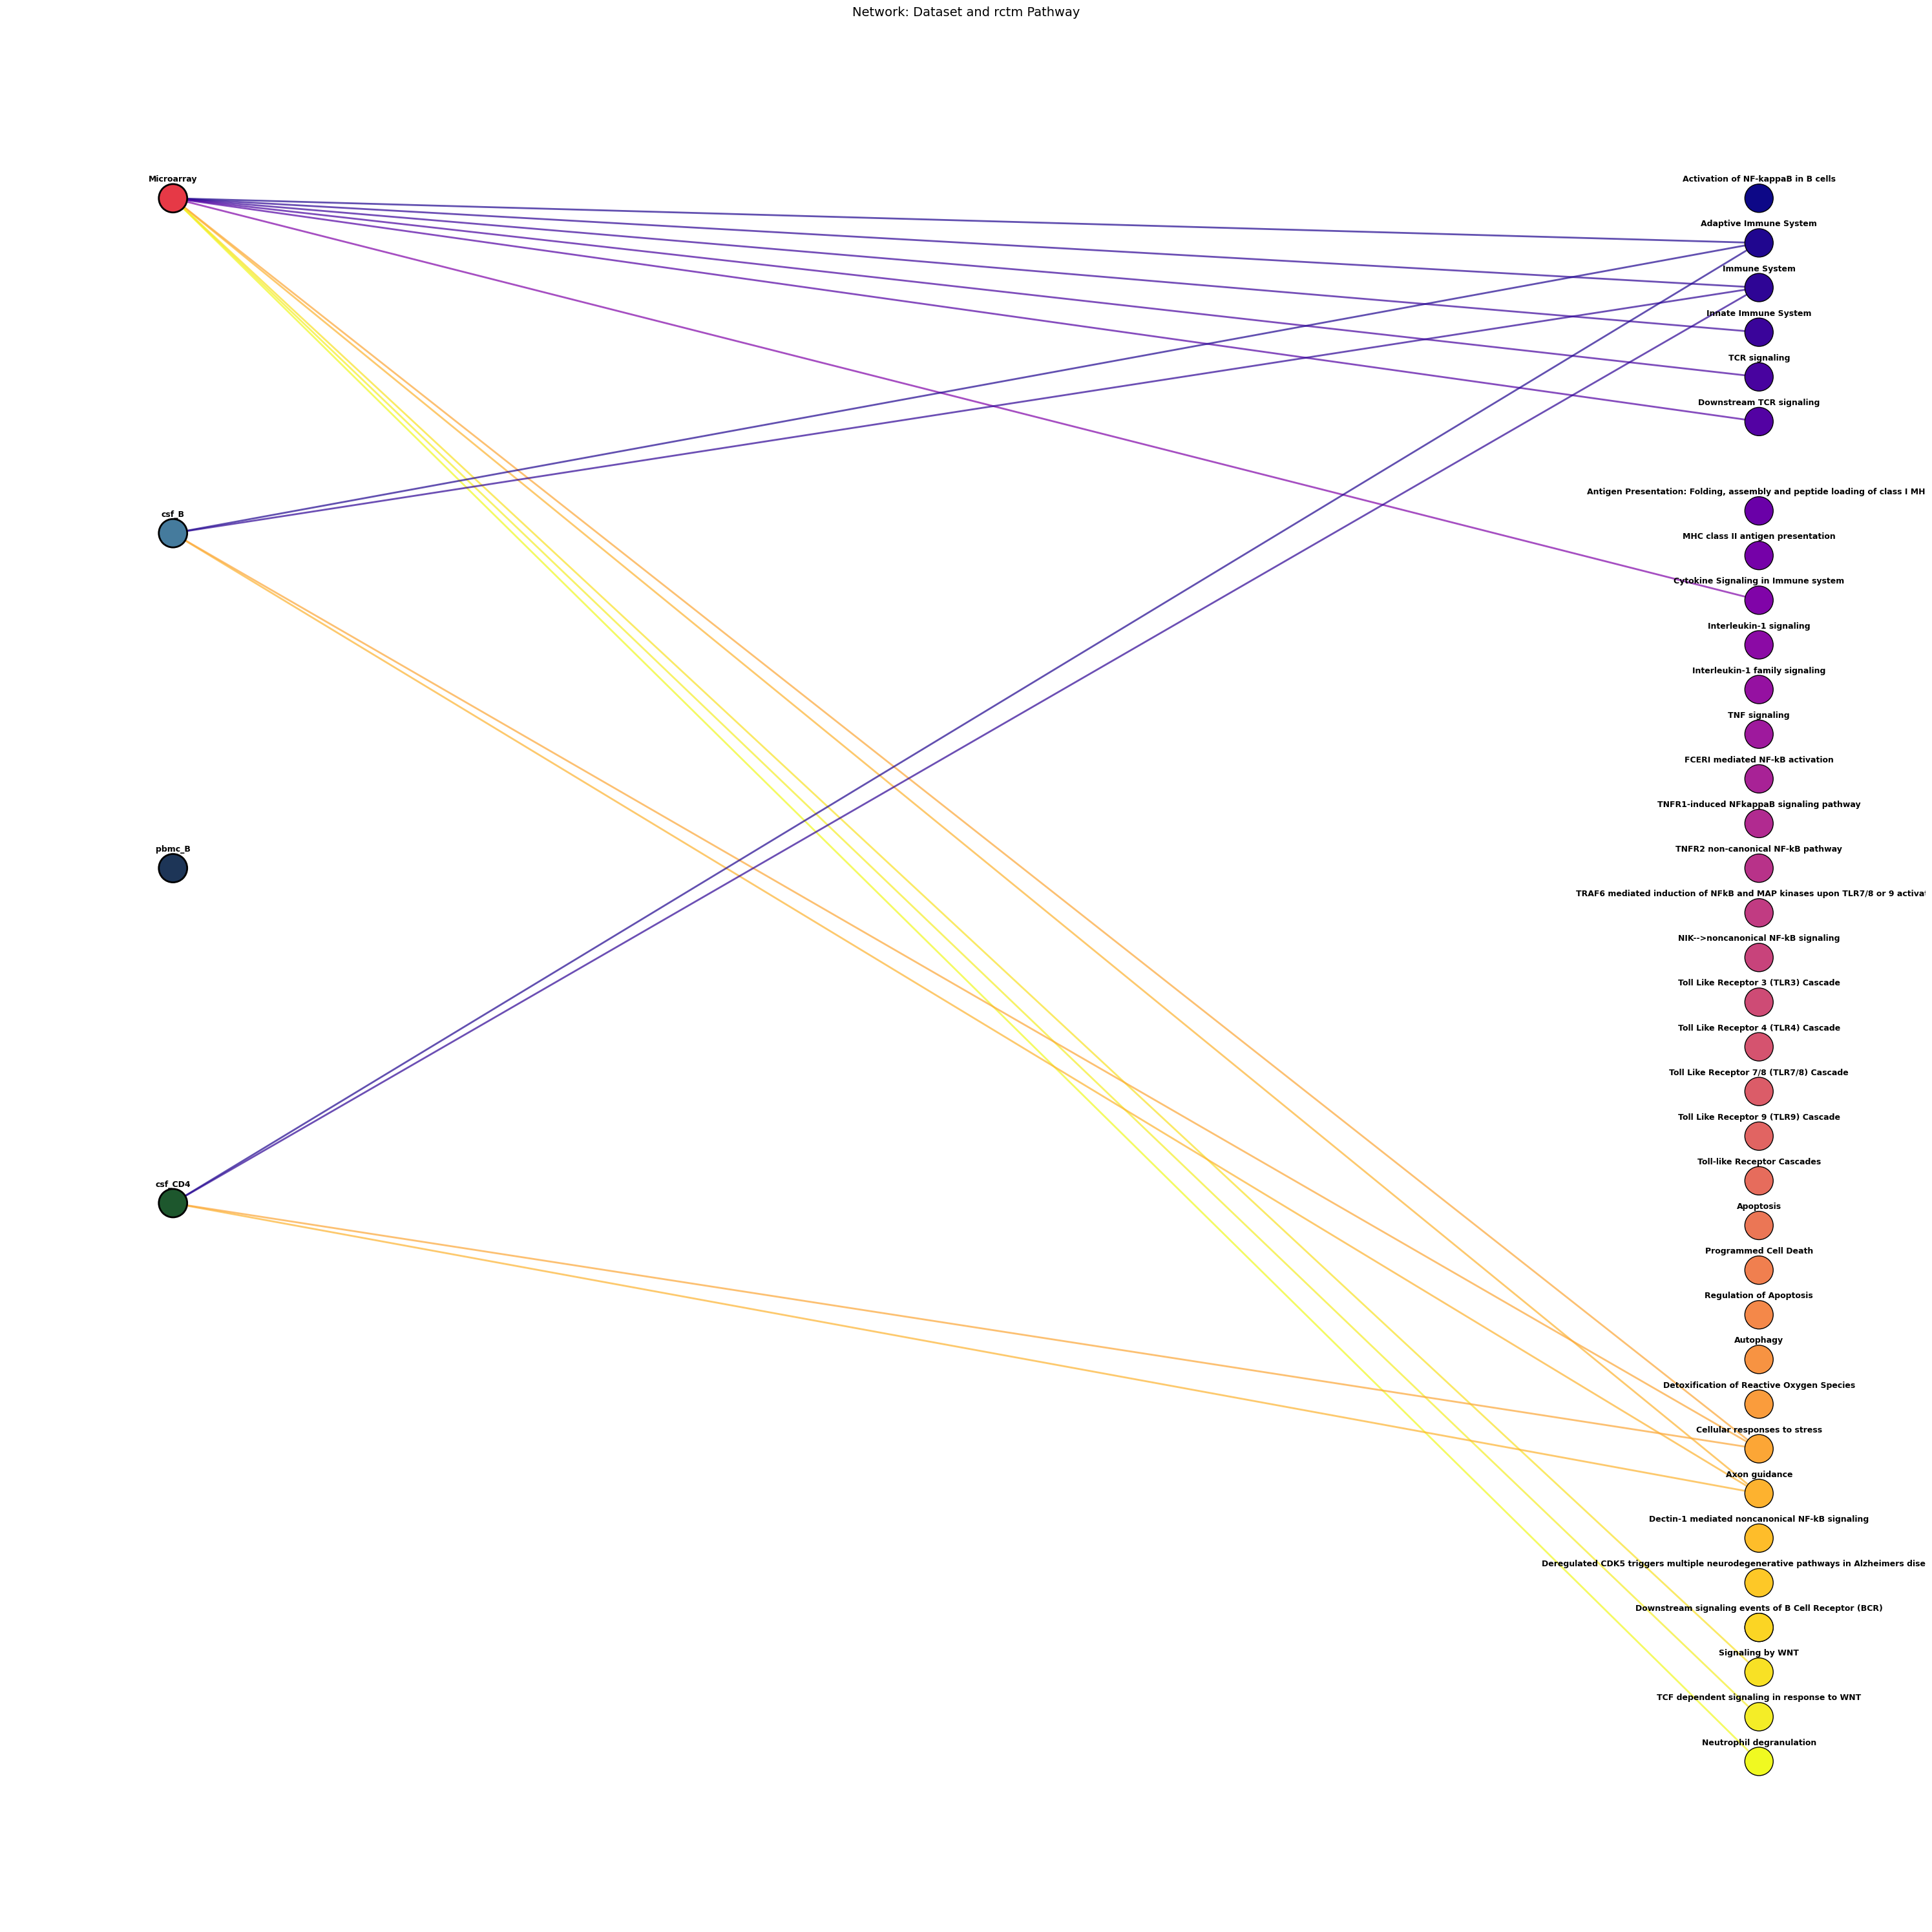

In [38]:
# Inizializzazione grafo
G = nx.Graph()

# Definizione nodi
dataset_nodes = ['Microarray', 'csf_B', 'pbmc_B', 'csf_CD4']
G.add_nodes_from(dataset_nodes, bipartite=0)
G.add_nodes_from(pathwaysOfInterest_rctm, bipartite=1)

# Aggiunta archi con controllo pathway
for pathway in microarray_Full_rctm['description']:
    if pathway in pathwaysOfInterest_rctm:
        G.add_edge('Microarray', pathway)

for pathway in csf_B_80Cluster_rctm['description']:
    if pathway in pathwaysOfInterest_rctm:
        G.add_edge('csf_B', pathway)

for pathway in pbmc_B_FullCluster_rctm['description']:
    if pathway in pathwaysOfInterest_rctm:
        G.add_edge('pbmc_B', pathway)

for pathway in csf_CD4_80Cluster_rctm['description']:
    if pathway in pathwaysOfInterest_rctm:
        G.add_edge('csf_CD4', pathway)

# Posizionamento nodi
pos = {}
dataset_colors = ['#E63946', '#457B9D', '#1D3557', "#1D572D"]  # Rosso, blu, blu scuro

# Posizione dataset (sinistra)
for i, node in enumerate(dataset_nodes):
    pos[node] = (0, -i * 300)

# Posizione pathway (destra)
for i, node in enumerate(pathwaysOfInterest_rctm):
    pos[node] = (3, -i * 40)  # Aumentato spazio orizzontale

# Palette vivaci per pathway (viridis, plasma, inferno, magma)
pathway_colors = plt.cm.plasma(np.linspace(0, 1, len(pathwaysOfInterest_rctm)))
pathway_color_dict = {pathway: pathway_colors[i] for i, pathway in enumerate(pathwaysOfInterest_rctm)}

# Creazione figura
plt.figure(figsize=(30, 30))

# Disegno nodi dataset
nx.draw_networkx_nodes(
    G, pos,
    nodelist=dataset_nodes,
    node_color=dataset_colors,
    node_size=1000,
    edgecolors='black',
    linewidths=2
)

# Disegno nodi pathway
nx.draw_networkx_nodes(
    G, pos,
    nodelist=pathwaysOfInterest_rctm,
    node_color=[pathway_color_dict[pathway] for pathway in pathwaysOfInterest_rctm],
    node_size=1000,
    edgecolors='black',
    linewidths=1
)

# Disegno archi colorati
for u, v in G.edges():
    pathway = v if u in dataset_nodes else u
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=pathway_color_dict[pathway],
        width=2,
        alpha=0.7
    )

label_pos = {k: (v[0], v[1] + 13) for k, v in pos.items() if k in pathwaysOfInterest_rctm+dataset_nodes}  # Sposta y +0.3

nx.draw_networkx_labels(
    G, 
    label_pos,  # Usa le nuove coordinate
    labels={n: n for n in pathwaysOfInterest_rctm+dataset_nodes},  # Solo pathway
    font_size=9,
    font_family='sans-serif',
    font_weight='bold',
    verticalalignment='bottom',  # Allinea il testo sotto alla posizione (quindi apparirà sopra il nodo)
    horizontalalignment='center'  # Centra orizzontalmente
)

# Titolo e layout
plt.title("Network: Dataset and rctm Pathway", fontsize=14, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

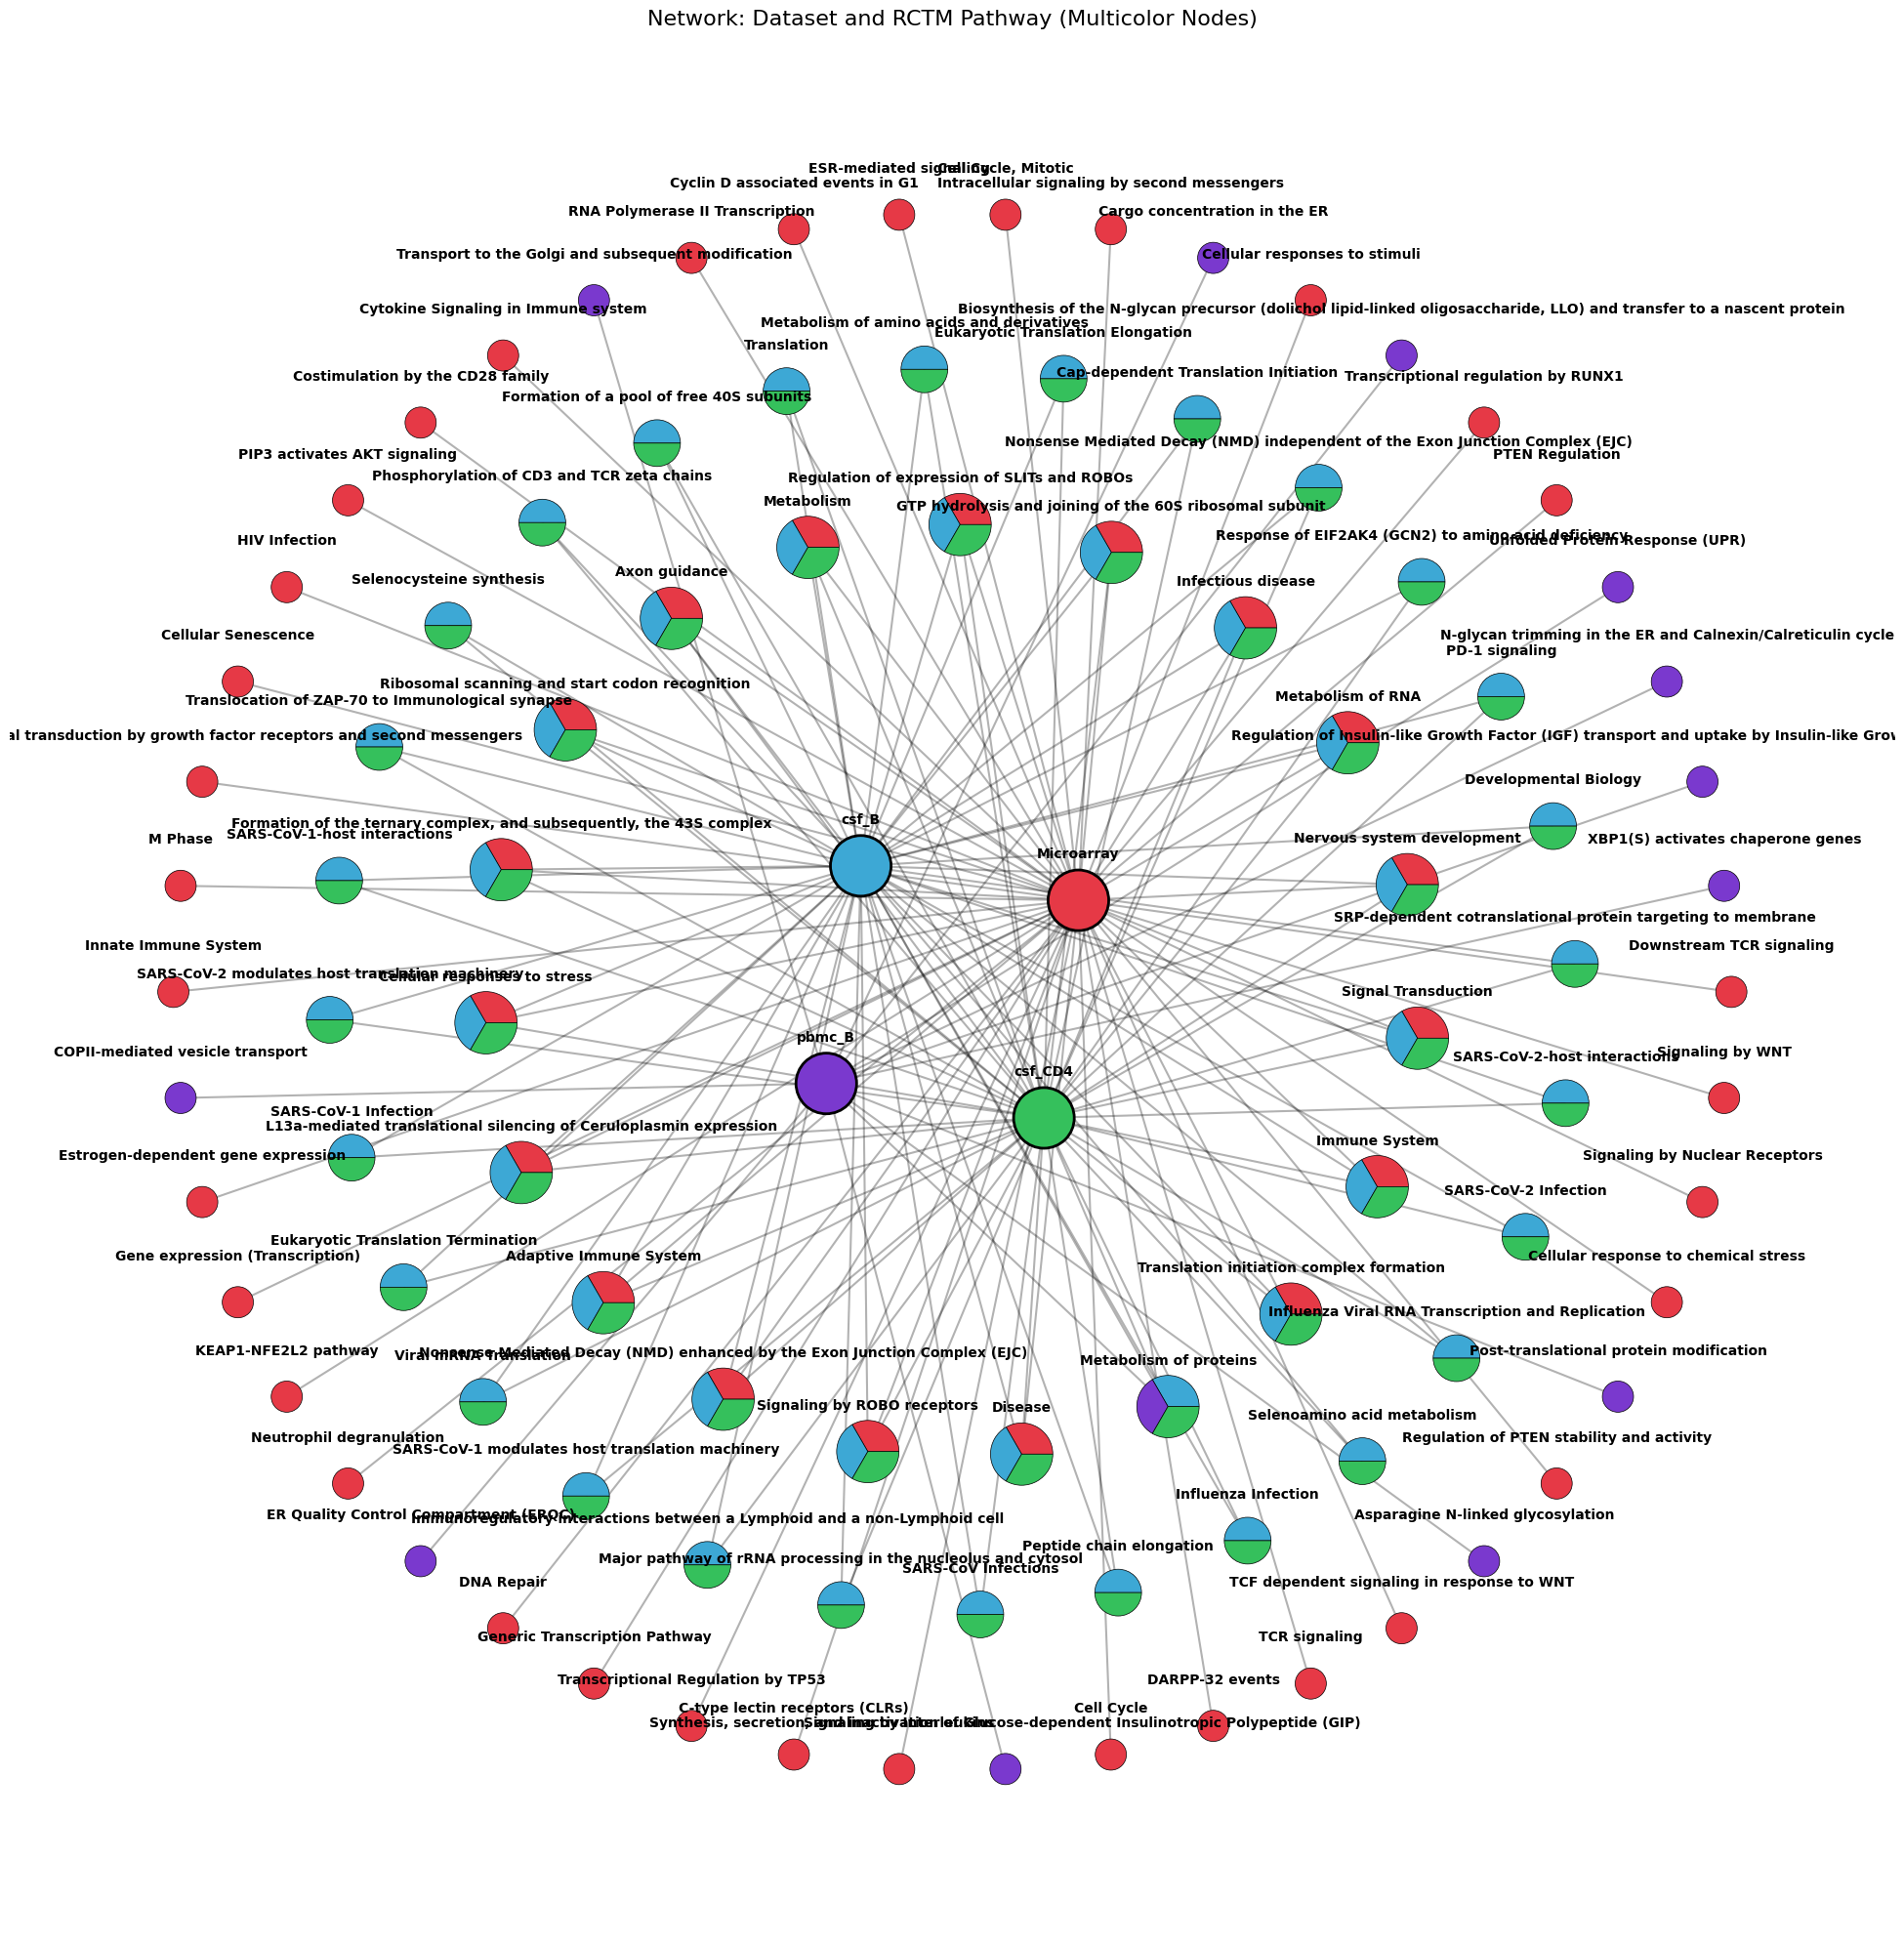

In [39]:
G = nx.Graph()

# Definizione nodi
dataset_nodes = ['Microarray', 'csf_B', 'pbmc_B', 'csf_CD4']
G.add_nodes_from(dataset_nodes, bipartite=0)
G.add_nodes_from(all_pathways_rctm, bipartite=1)

# Aggiunta archi
for pathway in microarray_Full_rctm['description']:
    if pathway in all_pathways_rctm:
        G.add_edge('Microarray', pathway)

for pathway in csf_B_80Cluster_rctm['description']:
    if pathway in all_pathways_rctm:
        G.add_edge('csf_B', pathway)

for pathway in pbmc_B_FullCluster_rctm['description']:
    if pathway in all_pathways_rctm:
        G.add_edge('pbmc_B', pathway)

for pathway in csf_CD4_80Cluster_rctm['description']:
    if pathway in all_pathways_rctm:
        G.add_edge('csf_CD4', pathway)

# -------------------------------
# POSIZIONAMENTO (shell_layout)
# -------------------------------

# Conta le connessioni di ciascun pathway ai dataset
pathway_dataset_count = {p: 0 for p in all_pathways_rctm}
for dataset in dataset_nodes:
    for neighbor in G.neighbors(dataset):
        if neighbor in all_pathways_rctm:
            pathway_dataset_count[neighbor] += 1

# Crea cerchi concentrici
pathway_circles = {i: [] for i in range(1, 5)}
for pathway, count in pathway_dataset_count.items():
    pathway_circles[count].append(pathway)

shells = [
    dataset_nodes,
    pathway_circles[4],
    pathway_circles[3],
    pathway_circles[2],
    pathway_circles[1],
]

pos = nx.shell_layout(G, shells)

# -------------------------------
# VISUALIZZAZIONE
# -------------------------------

# Colori per dataset
dataset_color_map = {
    'Microarray': '#E63946',
    'csf_B': "#3DA8D5",
    'pbmc_B': "#7A39CE",
    'csf_CD4': "#35C05C"
}

dataset_colors = [dataset_color_map[d] for d in dataset_nodes]

# Crea figura
plt.figure(figsize=(20, 20))
ax = plt.gca()
ax.set_aspect('equal')

# Disegna nodi dataset
nx.draw_networkx_nodes(
    G, pos,
    nodelist=dataset_nodes,
    node_color=dataset_colors,
    node_size=2000,
    edgecolors='black',
    linewidths=2
)

# Disegna archi (neri)
nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    edge_color='black',
    width=1.5,
    alpha=0.3
)

# Crea una mappa semplice: dimensione del nodo PATHWAY in base al numero di dataset connessi
radius_map = {4: 0.045, 3: 0.04, 2: 0.03, 1: 0.02}  # valori testabili

for pathway in all_pathways_rctm:
    x, y = pos[pathway]
    connected = [d for d in dataset_nodes if G.has_edge(d, pathway)]
    num = len(connected)
    radius = radius_map[num]  # raggio fisso in coordinate del grafo
    angle = 360 / num
    for i, d in enumerate(connected):
        wedge = Wedge(center=(x, y), r=radius,
                      theta1=i*angle, theta2=(i+1)*angle,
                      facecolor=dataset_color_map[d],
                      edgecolor='black', linewidth=0.5)
        ax.add_patch(wedge)

# Etichette
label_pos = {k: (v[0], v[1] + 0.06) for k, v in pos.items()}
nx.draw_networkx_labels(
    G, 
    label_pos,
    labels={n: n for n in dataset_nodes + list(all_pathways_rctm)},
    font_size=10,
    font_family='sans-serif',
    font_weight='bold',
    verticalalignment='center',
    horizontalalignment='center'
)

# Titolo e visualizzazione
plt.title("Network: Dataset and RCTM Pathway (Multicolor Nodes)", fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

<h4>Creo dizionario con tutti i geni per ogni pathway</h4>

In [40]:
dataframes_rctm = [
    microarray_Full_rctm,
    csf_B_80Cluster_rctm,
    pbmc_B_FullCluster_rctm,
    csf_CD4_80Cluster_rctm
]

all_pathDict_rctm = {}
for pathway in all_pathways_rctm:
    genes = set()
    for df in dataframes_rctm:
        extracted = extract_genes(df, pathway)
        genes |= extracted
    if genes:
        all_pathDict_rctm[pathway] = list(genes)

all_pathDict_rctm

{'Selenocysteine synthesis': ['UBA52',
  'RPL38',
  'RPS8',
  'RPL19',
  'RPL6',
  'RPS20',
  'RPL10',
  'RPS27A',
  'RPS15A',
  'RPLP2',
  'RPL23A',
  'RPS6',
  'RPL35A',
  'RPL39',
  'RPL37A',
  'RPL13',
  'RPL22',
  'RPL27A',
  'RPL32',
  'RPL21',
  'RPS16',
  'RPL18A',
  'RPL24',
  'RPL14',
  'RPL30',
  'RPS14',
  'RPL26',
  'RPL8',
  'RPS19',
  'RPL23',
  'RPL18',
  'RPS23',
  'RPL12',
  'RPS15',
  'RPL29',
  'RPS13',
  'RPL15',
  'RPL28',
  'RPL34',
  'RPL7A',
  'RPS11',
  'RPL31',
  'RPS12',
  'RPS3A',
  'RPLP1',
  'RPS28',
  'RPS17',
  'RPL9',
  'RPL37',
  'RPL13A',
  'RPL11',
  'RPL35',
  'RPL27',
  'RPS24',
  'RPS25',
  'RPL36'],
 'Translocation of ZAP-70 to Immunological synapse': ['CD247',
  'CD3E',
  'CD4',
  'CD3D',
  'CD3G',
  'LCK'],
 'Innate Immune System': ['DDOST',
  'IDH1',
  'NFKBIA',
  'S100A8',
  'TSPAN14',
  'CD4',
  'CLEC10A',
  'POLR3K',
  'PTPN6',
  'PPP2R5D',
  'ABI1',
  'RAB27A',
  'KRAS',
  'WAS',
  'CD68',
  'PANX1',
  'PPP2R1A',
  'MRE11',
  'RHOA',
  'P

<h4>Calcolo l'importanza a livello decisionale di ogni pathway sommando le importanze SHAP dei geni che lo compongono</h4>

In [41]:
def makePathImportance(pathDict, pathways, expl):
    pathImportance = {}
    for pathway, geneList in pathDict.items():
        pathImportance[pathway] = 0
        if pathway in pathways:
            for gene in geneList:
                if gene in expl:
                    pathImportance[pathway] += expl[gene]
    return {k: v for k, v in sorted(pathImportance.items(), key=lambda item: item[1], reverse=True)}

microarray_pathImportance = makePathImportance(all_pathDict_rctm, microarray_Full_rctm['description'].values, expl_sorted)
microarray_pathImportance

{'Signal Transduction': 4.603660698526177,
 'Immune System': 4.364499941784602,
 'Metabolism': 3.673097854505454,
 'Disease': 3.6232263631245525,
 'Gene expression (Transcription)': 2.9215146933840375,
 'RNA Polymerase II Transcription': 2.8520400250810245,
 'Generic Transcription Pathway': 2.6301235773113287,
 'Innate Immune System': 2.310895196798745,
 'Cytokine Signaling in Immune system': 2.2975847221786814,
 'Adaptive Immune System': 2.2260260258873603,
 'Infectious disease': 1.9089534135488324,
 'Cellular responses to stimuli': 1.863852170376611,
 'Cellular responses to stress': 1.7985180433263988,
 'Metabolism of RNA': 1.6015302736673371,
 'Cell Cycle': 1.4960702782764472,
 'Cell Cycle, Mitotic': 1.4610437175211188,
 'Signaling by Interleukins': 1.2745271137114182,
 'M Phase': 1.2001648738373611,
 'Signaling by Nuclear Receptors': 1.1758469048775282,
 'Transcriptional Regulation by TP53': 1.163357539057254,
 'Nervous system development': 1.0983021130328863,
 'Neutrophil degranul

<h2>Network Analysis</h2>

<h4>Tentativo di Hive plot</h4>

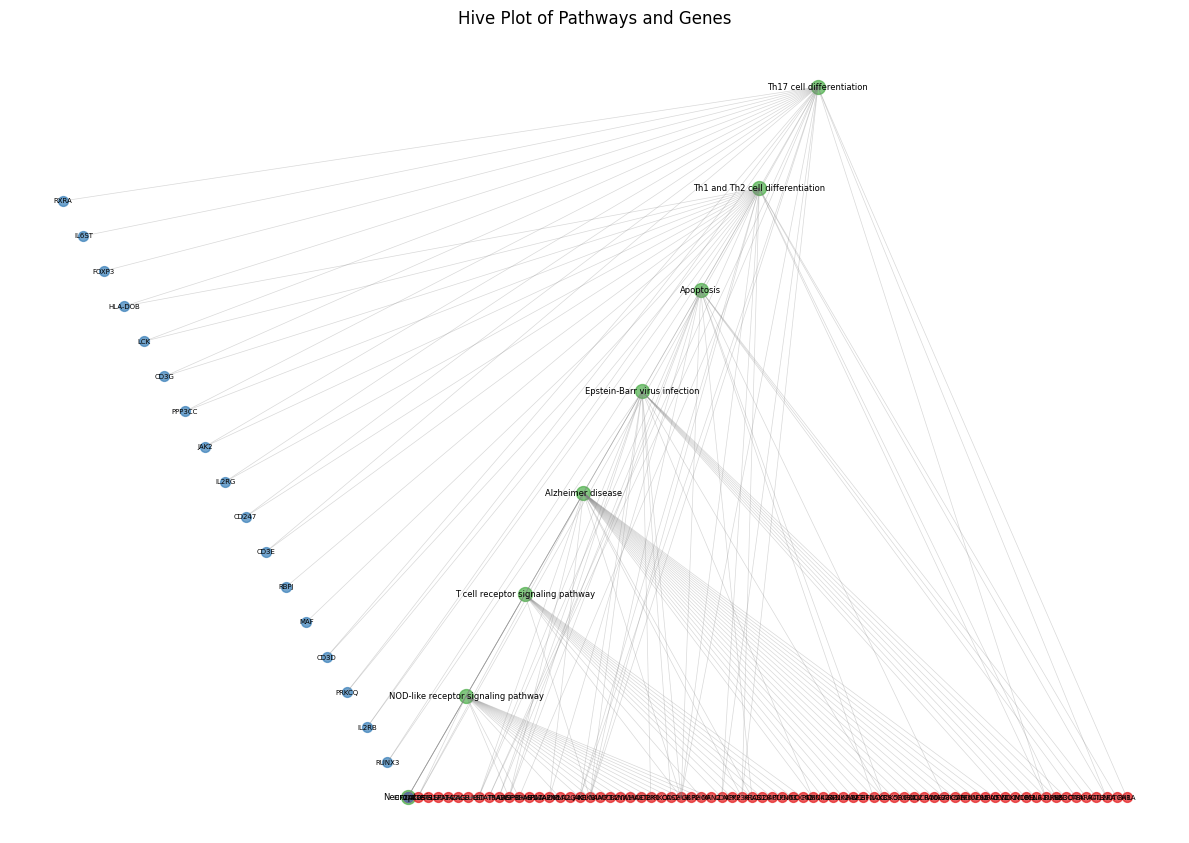

In [125]:
pathway_to_genes = defaultdict(set)
gene_to_pathways = defaultdict(set)
gene_to_datasets = defaultdict(set)

# Processa i dataset
for dataset, df in [('microarray', microarray_Full_kegg[microarray_Full_kegg['description'].isin(pathwaysOfInterest_kegg)]), 
                    ('csf_B', csf_B_80Cluster_kegg[csf_B_80Cluster_kegg['description'].isin(pathwaysOfInterest_kegg)])]:
    for _, row in df.iterrows():
        pathway = row['description']
        genes = row['genes'].split('|')
        
        for gene in genes:
            pathway_to_genes[pathway].add(gene)
            gene_to_pathways[gene].add(pathway)
            gene_to_datasets[gene].add(dataset)

colors = sns.color_palette("Set1", 3)


# 2. Crea il layout del hive plot
def create_hive_plot(pathway_to_genes, gene_to_datasets, gene_to_pathways):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    axes = {
        'microarray': {'angle': 0, 'color': colors[0]},
        'csf_B': {'angle': 120, 'color': colors[1]},
        'pathway': {'angle': 60, 'color': colors[2]},
    }

    
    # Calcola le posizioni dei nodi
    def get_position(axis, value, max_value, radius):
        angle = np.radians(axes[axis]['angle'])
        norm_value = value / max_value if max_value > 0 else 0
        x = radius * norm_value * np.cos(angle)
        y = radius * norm_value * np.sin(angle)
        return x, y
    
    # Disegna gli assi
    max_radius = 0
    for axis_name, axis in axes.items():
        angle = np.radians(axis['angle'])
        x = max_radius * np.cos(angle)
        y = max_radius * np.sin(angle)
        ax.plot([0, x], [0, y], color=axis['color'], alpha=0.3)
    
    # Disegna i nodi pathway
    pathway_nodes = {}
    pathway_count = len(pathway_to_genes)
    for i, pathway in enumerate(pathway_to_genes):
        x, y = get_position('pathway', i, pathway_count, 9)
        pathway_nodes[pathway] = (x, y)
        ax.scatter(x, y, color=colors[2], s=100, alpha=0.7)
        ax.text(x, y, pathway, fontsize=6, ha='center', va='center')
    
    # Disegna i nodi gene per ogni dataset
    gene_nodes = {}
    for dataset in ['microarray', 'csf_B']:
        dataset_genes = [g for g in gene_to_datasets if dataset in gene_to_datasets[g]]
        gene_count = len(dataset_genes)
        
        for i, gene in enumerate(dataset_genes):
            x, y = get_position(dataset, i, gene_count, 7)
            gene_nodes[(gene, dataset)] = (x, y)
            ax.scatter(x, y, color=axes[dataset]['color'], s=50, alpha=0.7)
            ax.text(x, y, gene, fontsize=5, ha='center', va='center')
    
    # Disegna le connessioni
    for pathway in pathway_to_genes:
        px, py = pathway_nodes[pathway]
        for gene in pathway_to_genes[pathway]:
            for dataset in gene_to_datasets[gene]:
                if (gene, dataset) in gene_nodes:
                    gx, gy = gene_nodes[(gene, dataset)]
                    # Crea una curva bezier per la connessione
                    verts = [
                        (px, py),  # P1: punto iniziale (pathway)
                        ((px+gx)/2, (py+gy)/2),  # Punto di controllo
                        (gx, gy)   # P2: punto finale (gene)
                    ]
                    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
                    path = Path(verts, codes)
                    patch = patches.PathPatch(path, facecolor='none', 
                                           edgecolor='grey', lw=0.5, alpha=0.3)
                    ax.add_patch(patch)
    
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title('Hive Plot of Pathways and Genes', pad=20)
    plt.tight_layout()
    plt.show()

create_hive_plot(pathway_to_genes, gene_to_datasets, gene_to_pathways)

<h3>Sovrapposizione rete microarray e rete CSF_B</h3>

In [43]:
G1 = nx.read_graphml("../../Reti/MicroarrayNetwork.graphml")
G1 = nx.relabel_nodes(G1, lambda n: G1.nodes[n].get("display name", n))
G2 = nx.read_graphml("../../Reti/csfBNetwork.graphml")
G2 = nx.relabel_nodes(G2, lambda n: G2.nodes[n].get("display name", n))

# Intersezione dei nodi e archi
common_nodes = set(G1.nodes()).intersection(G2.nodes())
common_edges = set(G1.edges()).intersection(G2.edges())

# Crea sottografo con gli archi e nodi comuni
G_common = nx.Graph()
G_common.add_edges_from(common_edges)
G_common.add_nodes_from(common_nodes)

# Trova componenti connesse (ogni path comune disgiunto)
paths = list(nx.connected_components(G_common))

Rete colorata per componenti connesse e pathway in comune, rete microarray grigia sottofondo

C:\Users\samue\AppData\Local\Temp\ipykernel_1756\1954631072.py:57: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


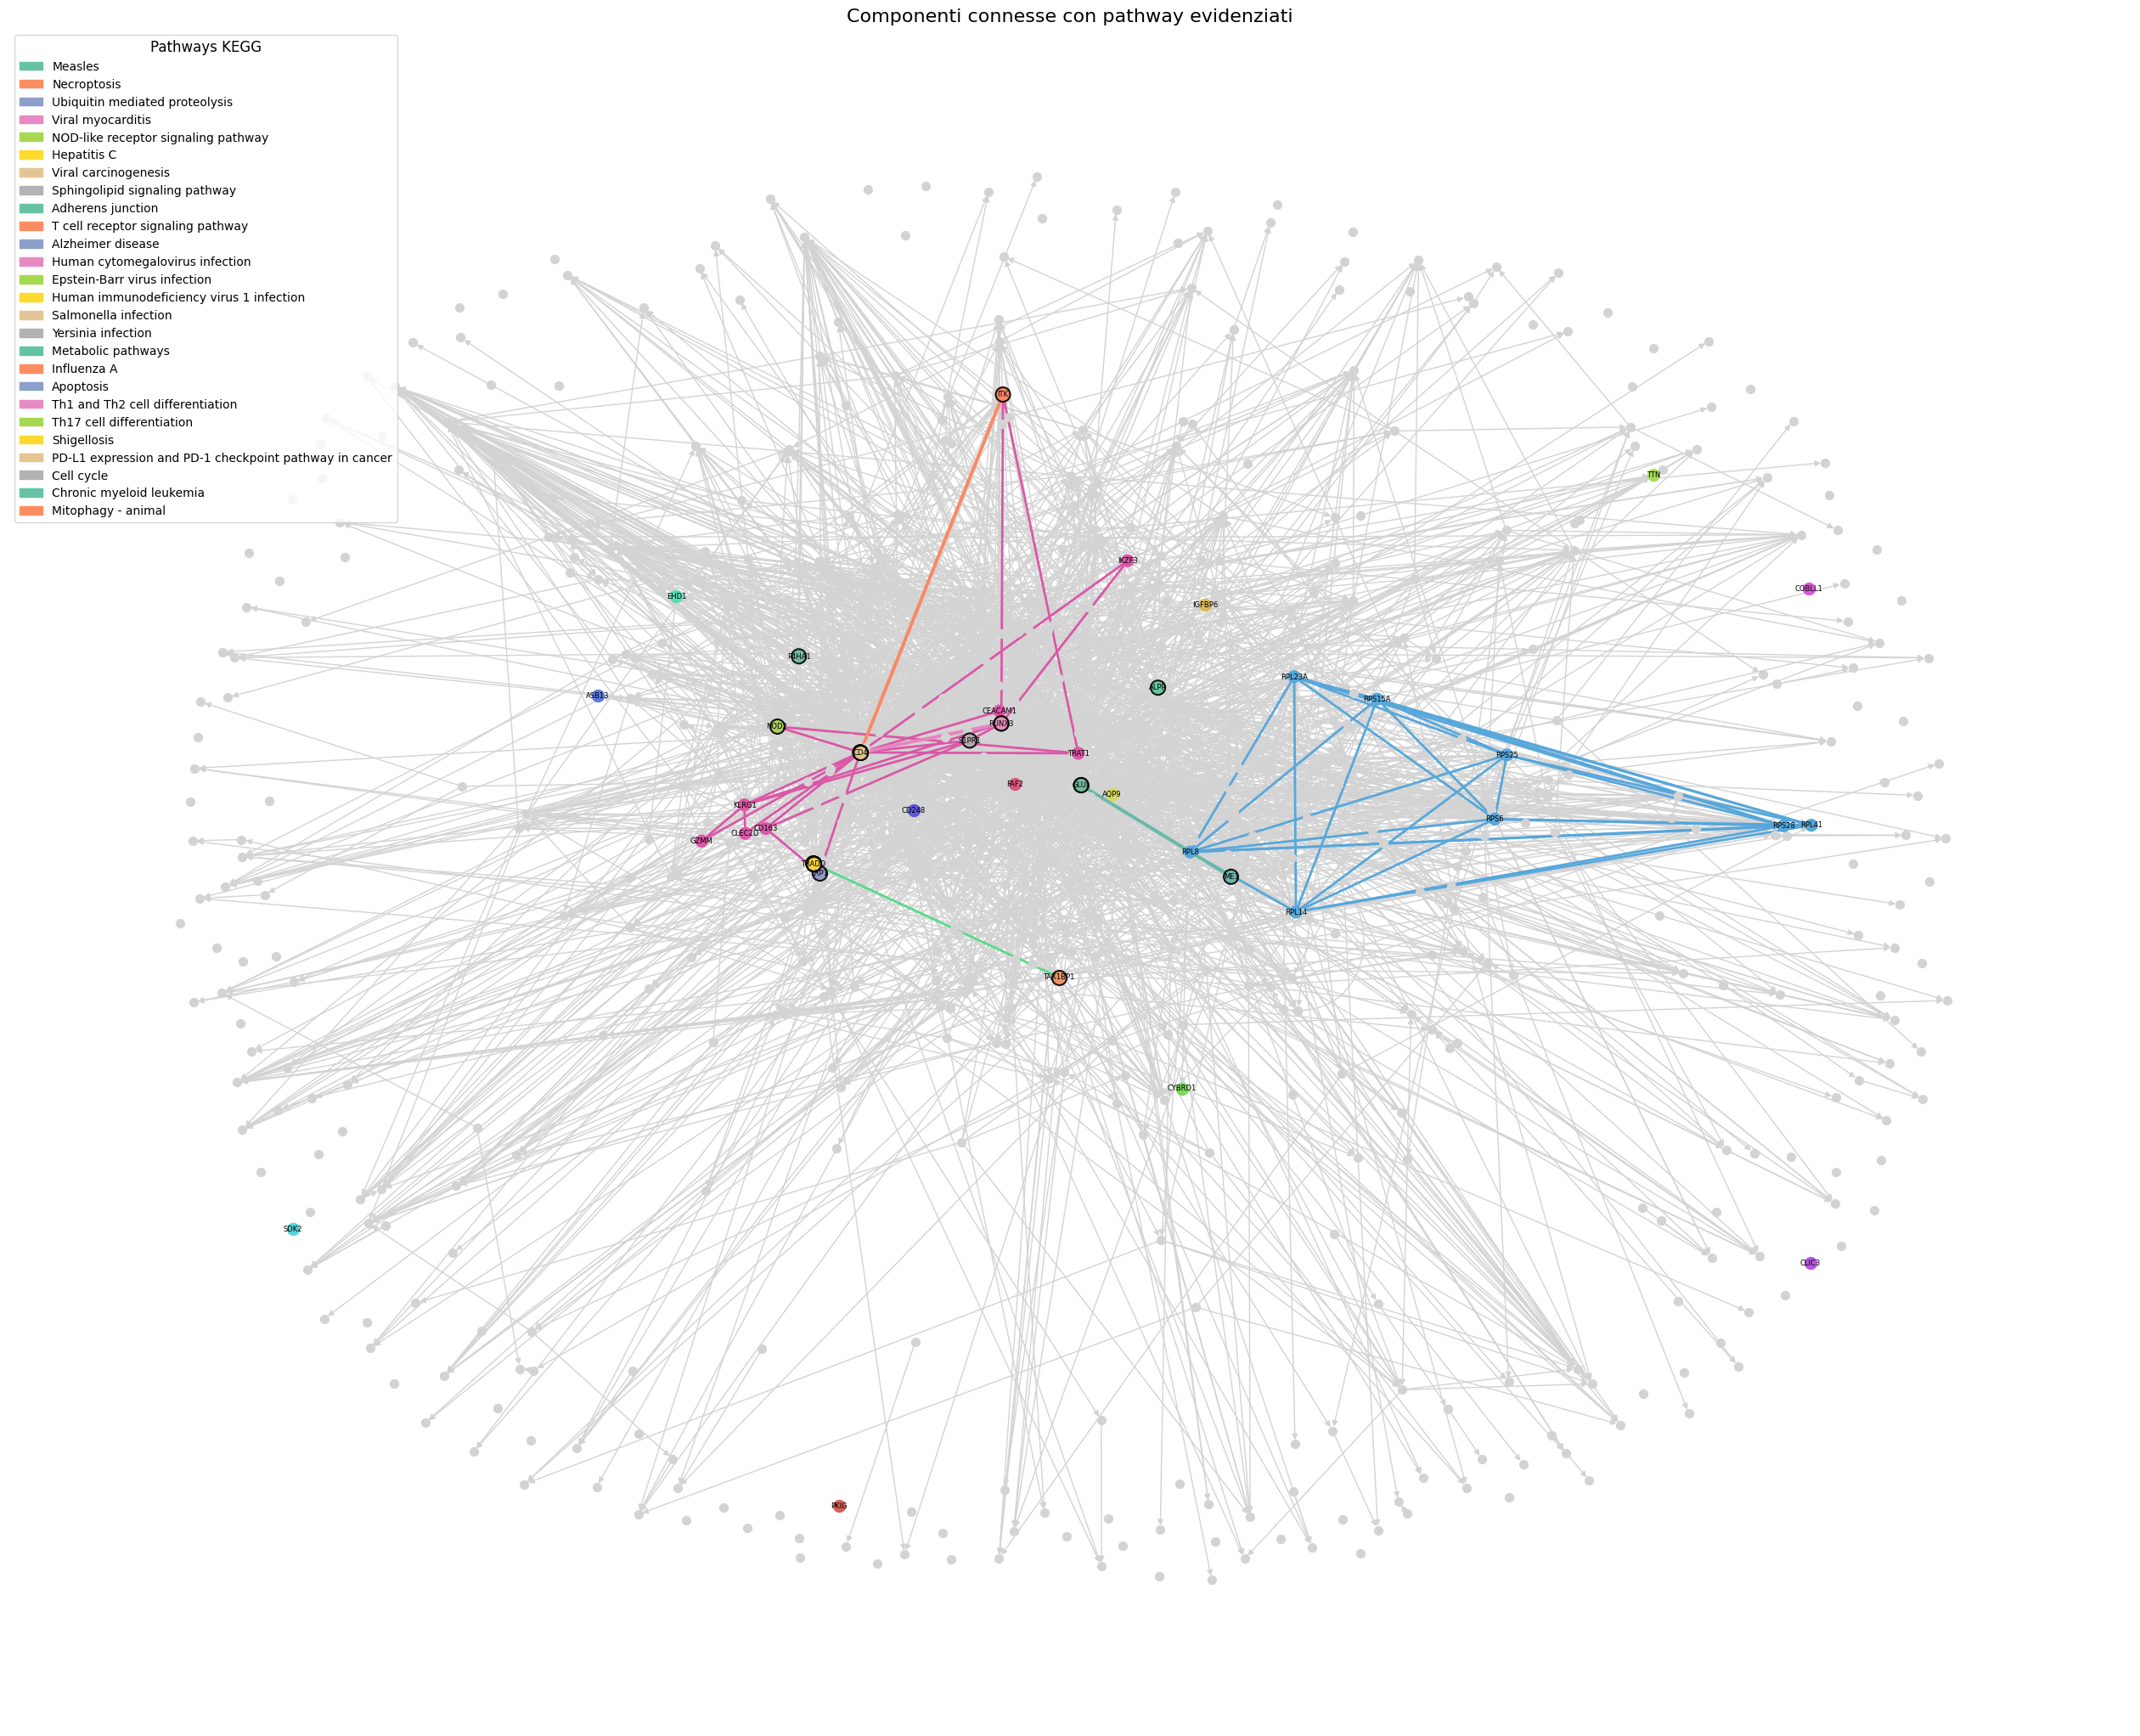

In [44]:
microarrayPathDict = {}
for pathway in microarray_Full_kegg['description']:
    genes = set()
    extracted = extract_genes(microarray_Full_kegg, pathway)
    genes |= extracted
    if genes:
        microarrayPathDict[pathway] = list(genes)

# Layout condiviso
pos = nx.spring_layout(G1, seed=42)

# Colori componenti connesse
component_colors = sns.color_palette("hls", len(paths))
random.shuffle(component_colors)

# --- 3. Plotting ---

plt.figure(figsize=(25, 20))

# Sfondo in grigio
nx.draw(G1, pos, node_color='lightgray', edge_color='lightgray', with_labels=False, node_size=50)

# Componenti connesse colorate
for i, component in enumerate(paths):
    subgraph = G_common.subgraph(component)
    color = component_colors[i % len(component_colors)]
    nx.draw_networkx_nodes(subgraph, pos, node_color=[color]*len(subgraph.nodes()), node_size=100)
    nx.draw_networkx_edges(subgraph, pos, edge_color=color, width=2)

# Colori per pathway
pathway_colors = sns.color_palette("Set2", len(microarrayPathDict))
pathway_color_map = dict(zip(microarrayPathDict.keys(), pathway_colors))

# Sovrapposizione pathway
for pathway, genes in microarrayPathDict.items():
    valid_genes = [gene for gene in genes if gene in G_common.nodes()]
    if not valid_genes:
        continue

    # Nodi del pathway
    nx.draw_networkx_nodes(
        G_common, pos,
        nodelist=valid_genes,
        node_color=[pathway_color_map[pathway]] * len(valid_genes),
        node_size=150,
        edgecolors='black',
        linewidths=1.5,
        alpha=0.9
    )

    # Archi del pathway (entrambi i nodi nel pathway)
    pathway_edges = [
        edge for edge in G_common.edges(valid_genes)
        if edge[0] in valid_genes and edge[1] in valid_genes
    ]

    nx.draw_networkx_edges(
        G_common, pos,
        edgelist=pathway_edges,
        edge_color=[pathway_color_map[pathway]] * len(pathway_edges),
        width=3,
        alpha=0.9
    )

# Etichette nodi
nx.draw_networkx_labels(G_common, pos, font_size=6)

# --- 4. Legenda ---

legend_patches = [
    mpatches.Patch(color=pathway_color_map[pathway], label=pathway)
    for pathway in microarrayPathDict.keys()
]

plt.legend(
    handles=legend_patches,
    title="Pathways KEGG",
    loc="upper left",
    fontsize=10,
    title_fontsize=12,
    frameon=True
)

# Titolo e visualizzazione
plt.axis('off')
plt.title("Componenti connesse con pathway evidenziati", fontsize=16)
plt.show()

<h3>Community analysis</h3>

In [45]:
G1_undirected = G1.to_undirected()
G2_undirected = G2.to_undirected()

def detect_modules(graph):
    partition = community_louvain.best_partition(graph)
    nx.set_node_attributes(graph, partition, 'module')
    return partition

modules1 = detect_modules(G1_undirected)
modules2 = detect_modules(G2_undirected)

**Interpretazione delle metriche di centralità nei grafi**

- **Degree**: misura il numero di connessioni dirette di un nodo. Un valore alto indica che il nodo è molto connesso e potenzialmente importante per la comunicazione locale nella rete.

- **Betweenness**: quantifica quante volte un nodo si trova sul percorso più breve tra altri nodi. Un valore elevato suggerisce che il nodo agisce da "ponte" o snodo critico per il flusso di informazioni.

- **Closeness**: rappresenta l'inverso della distanza media di un nodo da tutti gli altri nodi. Un nodo con closeness alta può raggiungere rapidamente tutti gli altri nodi della rete.

- **Eigenvector**: valuta l'importanza di un nodo considerando anche l'importanza dei suoi vicini. Un nodo con eigenvector centrality alta è collegato a nodi anch'essi centrali e influenti.

- **PageRank**: simile all'eigenvector, ma tiene conto della direzione e del peso dei collegamenti. Un nodo con PageRank alto è raggiunto frequentemente tramite percorsi casuali nella rete, indicando una posizione di rilievo globale.

Clustering medio: 0.22663939709123437
Lunghezza media dei cammini nella componente connessa più grande: 3.3660042557418532


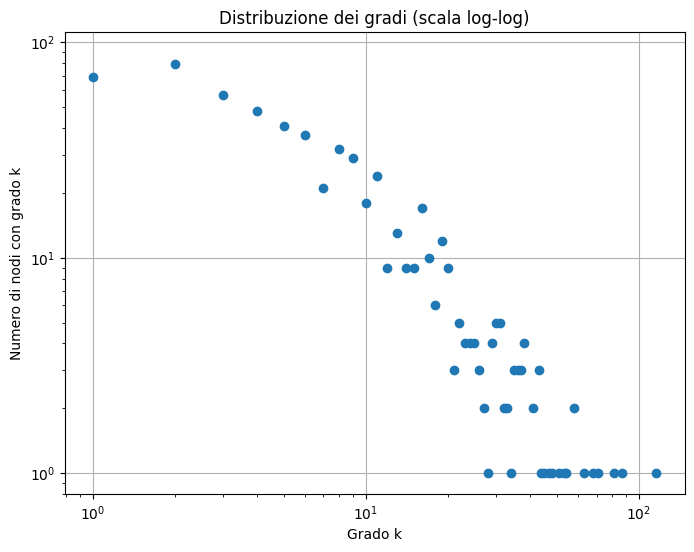

In [46]:
clustering = nx.average_clustering(G1_undirected)
print("Clustering medio:", clustering)

largest_cc = max(nx.connected_components(G1_undirected), key=len)
G1_lcc = G1_undirected.subgraph(largest_cc).copy()
path_length = nx.average_shortest_path_length(G1_lcc)
print("Lunghezza media dei cammini nella componente connessa più grande:", path_length)

# Distribuzione dei gradi
degrees = [d for n, d in G1_undirected.degree()]
degree_counts = np.bincount(degrees)
k = np.arange(len(degree_counts))

# Evita di considerare i gradi zero
nonzero = degree_counts > 0
k = k[nonzero]
degree_counts = degree_counts[nonzero]

# Grafico log-log
plt.figure(figsize=(8, 6))
plt.loglog(k, degree_counts, marker='o', linestyle='None')
plt.title("Distribuzione dei gradi (scala log-log)")
plt.xlabel("Grado k")
plt.ylabel("Numero di nodi con grado k")
plt.grid(True)
plt.show()

In [47]:
def compute_node_importance_metrics(G):
    if G.is_directed():
        G = G.to_undirected()

    print("Calcolo delle metriche di centralità...")

    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    closeness_centrality = nx.closeness_centrality(G)
    
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        eigenvector_centrality = {n: None for n in G.nodes}
        print("⚠️ Eigenvector centrality non converge")

    # PageRank
    pagerank = nx.pagerank(G)

    # Costruzione DataFrame
    df = pd.DataFrame({
        'Node': list(G.nodes),
        'Degree': [degree_centrality[n] for n in G.nodes],
        'Betweenness': [betweenness_centrality[n] for n in G.nodes],
        'Closeness': [closeness_centrality[n] for n in G.nodes],
        'Eigenvector': [eigenvector_centrality[n] for n in G.nodes],
        'PageRank': [pagerank[n] for n in G.nodes]
    })

    return df

importances_G1 = compute_node_importance_metrics(G1_undirected)
importances_G1

Calcolo delle metriche di centralità...


Node    Degree  Betweenness  Closeness   Eigenvector  PageRank
0      TWSG1  0.000000     0.000000   0.000000  8.250805e-30  0.000234
1     SLC7A7  0.000000     0.000000   0.000000  8.250805e-30  0.000234
2      ADAT1  0.000000     0.000000   0.000000  8.250805e-30  0.000234
3      VGLL4  0.000000     0.000000   0.000000  8.250805e-30  0.000234
4     NIBAN1  0.000000     0.000000   0.000000  8.250805e-30  0.000234
..       ...       ...          ...        ...           ...       ...
711    BACE2  0.005594     0.000381   0.264435  8.528669e-03  0.000811
712  NECTIN1  0.006993     0.000718   0.274773  1.591631e-02  0.000890
713     LY86  0.004196     0.001843   0.261330  6.772120e-03  0.000773
714     RARA  0.040559     0.006825   0.334896  8.273941e-02  0.003617
715      CD4  0.113287     0.054538   0.371977  1.899583e-01  0.009971

[716 rows x 6 columns]

In [48]:
percent = int(importances_G1.shape[0] / 100 * 10)

print("Importanze ordinate per Grado:")
importances_G1.sort_values(by='Degree', ascending=False, inplace=True)
print(importances_G1[['Node', 'Degree']][:percent])

print("Importanze ordinate per Betweenness:")
importances_G1.sort_values(by='Betweenness', ascending=False, inplace=True)
print(importances_G1[['Node', 'Betweenness']].head(percent))

print("Importanze ordinate per Closeness:")
importances_G1.sort_values(by='Closeness', ascending=False, inplace=True)
print(importances_G1[['Node', 'Closeness']].head(percent))

print("Importanze ordinate per Eigenvector:")
importances_G1.sort_values(by='Eigenvector', ascending=False, inplace=True)
print(importances_G1[['Node', 'Eigenvector']].head(percent))

print("Importanze ordinate per PageRank:")
importances_G1.sort_values(by='PageRank', ascending=False, inplace=True)
print(importances_G1[['Node', 'PageRank']].head(percent))

Importanze ordinate per Grado:
         Node    Degree
651      ACTB  0.162238
677  HSP90AB1  0.121678
715       CD4  0.113287
638      IL1B  0.099301
669      KRAS  0.095105
..        ...       ...
647     CD163  0.032168
635  HLA-DRB1  0.032168
672      CD63  0.032168
488     EWSR1  0.032168
499      TAF1  0.030769

[71 rows x 2 columns]
Importanze ordinate per Betweenness:
         Node  Betweenness
651      ACTB     0.118752
677  HSP90AB1     0.059173
715       CD4     0.054538
669      KRAS     0.038581
676      CYCS     0.038024
..        ...          ...
271   TMEM165     0.006981
278    TXNRD1     0.006955
407   SMARCE1     0.006853
714      RARA     0.006825
302     GNAI3     0.006627

[71 rows x 2 columns]
Importanze ordinate per Closeness:
         Node  Closeness
651      ACTB   0.419607
677  HSP90AB1   0.394796
669      KRAS   0.375904
650     CCND1   0.374849
715       CD4   0.371977
..        ...        ...
385      ATF6   0.317952
659      NOD2   0.317763
643      CD68 

In [49]:
print(list(importances_G1['Node'][:50].values))

['ACTB', 'HSP90AB1', 'CD4', 'IL1B', 'KRAS', 'CYCS', 'CCND1', 'MDM2', 'HSPA5', 'H2BC21', 'CDC42', 'NFKBIA', 'RHOA', 'CCL2', 'CXCR4', 'NEDD8', 'ABL1', 'RPS6', 'NOTCH1', 'POLR2C', 'IDH1', 'SOD1', 'BTRC', 'ACO2', 'ENO1', 'RPL4', 'CASP8', 'RPL8', 'EIF2AK2', 'RPL23A', 'PRKCA', 'CDKN1B', 'RBM39', 'YWHAE', 'AGO2', 'RPSA', 'PARK7', 'PALB2', 'PSMC4', 'TBK1', 'PPP2R1A', 'CD28', 'STAT5A', 'EIF4G1', 'EIF2AK3', 'RPS28', 'RARA', 'CD40LG', 'H2BC5', 'SF3B1']
